In [2]:
# Simple test to verify ResNet vs ProbResNet_BN equivalence
import torch
import torch.nn.functional as F
import math

# Import your models
from models import ResNet, ProbResNet_bn  # Import ResNet class directly, not ResNet50_new

print("=== Simple ResNet vs ProbResNet_BN Test ===")

# Set device - force CPU for this test
device = torch.device("cpu")  # Force CPU since CUDA not available
print(f"Using device: {device}")

try:
    # 1. Create standard ResNet directly on CPU (bypass ResNet50_new)
    standard_resnet = ResNet().to(device)  # Create ResNet directly and move to CPU
    print("✓ Standard ResNet created on CPU")
    
    # 2. Create ProbResNet_BN initialized from standard ResNet
    rho_prior = math.log(math.exp(0.1) - 1.0)  # Convert sigma_prior=0.1 to rho_prior
    prob_resnet = ProbResNet_bn(
        rho_prior=rho_prior, 
        init_net=standard_resnet, 
        device=device  # Explicitly pass CPU device
    )
    prob_resnet = prob_resnet.to(device)  # Ensure it's on CPU
    print("✓ ProbResNet_BN created and initialized from standard ResNet")
    
    # 3. Set both models to eval mode
    standard_resnet.eval()
    prob_resnet.eval()
    
    # 4. Create test input (batch_size=2 for faster testing)
    test_input = torch.randn(2, 3, 224, 224).to(device)  # Ensure input is on CPU
    print(f"✓ Test input created: {test_input.shape}")
    print(f"Test input min/max: {test_input.min():.4f} / {test_input.max():.4f}")
    
    # 5. Get outputs
    with torch.no_grad():
        # Standard ResNet output (normalized embeddings)
        print("\n--- Standard ResNet Forward Pass ---")
        standard_output = standard_resnet(test_input)
        
        # ProbResNet output with sample=False (use posterior mean)
        print("--- ProbResNet Forward Pass (sample=False) ---")
        prob_output = prob_resnet(test_input, sample=False)
        
        print(f"\n=== OUTPUT DETAILS ===")
        print(f"Standard output shape: {standard_output.shape}")
        print(f"Standard output dtype: {standard_output.dtype}")
        print(f"Standard output device: {standard_output.device}")
        print(f"Standard output min/max: {standard_output.min():.6f} / {standard_output.max():.6f}")
        print(f"Standard output mean/std: {standard_output.mean():.6f} / {standard_output.std():.6f}")
        print(f"Standard output first few values: {standard_output[0, :5]}")
        
        print(f"\nProbabilistic output shape: {prob_output.shape}")
        print(f"Probabilistic output dtype: {prob_output.dtype}")
        print(f"Probabilistic output device: {prob_output.device}")
        print(f"Probabilistic output min/max: {prob_output.min():.6f} / {prob_output.max():.6f}")
        print(f"Probabilistic output mean/std: {prob_output.mean():.6f} / {prob_output.std():.6f}")
        print(f"Probabilistic output first few values: {prob_output[0, :5]}")
        
        # 6. Compare outputs
        if standard_output.shape == prob_output.shape:
            # Compute differences
            abs_diff = torch.abs(standard_output - prob_output)
            mean_diff = torch.mean(abs_diff).item()
            max_diff = torch.max(abs_diff).item()
            min_diff = torch.min(abs_diff).item()
            
            print(f"\n=== COMPARISON RESULTS ===")
            print(f"Mean absolute difference: {mean_diff:.6f}")
            print(f"Max absolute difference: {max_diff:.6f}")
            print(f"Min absolute difference: {min_diff:.6f}")
            print(f"Std of absolute differences: {abs_diff.std():.6f}")
            
            # Show element-wise differences for first sample
            print(f"First sample differences (first 10 elements): {abs_diff[0, :10]}")
            
            # Cosine similarity for overall comparison
            cos_sim = F.cosine_similarity(
                standard_output.flatten(), 
                prob_output.flatten(), 
                dim=0
            ).item()
            print(f"Cosine similarity: {cos_sim:.6f}")
            
            # L2 norm comparison
            standard_norm = torch.norm(standard_output).item()
            prob_norm = torch.norm(prob_output).item()
            print(f"Standard output L2 norm: {standard_norm:.6f}")
            print(f"Probabilistic output L2 norm: {prob_norm:.6f}")
            print(f"L2 norm difference: {abs(standard_norm - prob_norm):.6f}")
            
            # Check if models are similar
            if mean_diff < 0.1 and cos_sim > 0.9:
                print("\n✅ SUCCESS: Models produce similar outputs!")
                print("   The probabilistic model is properly initialized.")
            elif mean_diff < 0.5:
                print("\n⚠️  PARTIAL SUCCESS: Some differences but models are related")
                print("   This might be due to architectural adaptations.")
            else:
                print("\n❌ WARNING: Large differences detected")
                print("   Models may not be properly aligned.")
                
        else:
            print("❌ ERROR: Output shapes don't match!")
            print(f"  Standard: {standard_output.shape}")
            print(f"  Probabilistic: {prob_output.shape}")
    
    # 7. Test sampling behavior
    print(f"\n=== TESTING SAMPLING BEHAVIOR ===")
    prob_resnet.train()  # Enable sampling mode
    
    with torch.no_grad():
        # Generate multiple samples
        print("Generating multiple samples from probabilistic model...")
        samples = []
        for i in range(3):
            print(f"  Generating sample {i+1}...")
            sample_output = prob_resnet(test_input, sample=True)
            samples.append(sample_output)
            print(f"    Sample {i+1} mean/std: {sample_output.mean():.6f} / {sample_output.std():.6f}")
            print(f"    Sample {i+1} first few values: {sample_output[0, :5]}")
        
        # Check variance across samples
        if len(samples) > 1:
            stacked_samples = torch.stack(samples)
            sample_variance = torch.var(stacked_samples, dim=0).mean().item()
            
            print(f"\nMean variance across 3 samples: {sample_variance:.6f}")
            
            # Compare each pair of samples
            for i in range(len(samples)):
                for j in range(i+1, len(samples)):
                    diff = torch.mean(torch.abs(samples[i] - samples[j])).item()
                    print(f"  Difference between sample {i+1} and {j+1}: {diff:.6f}")
            
            if sample_variance > 1e-6:
                print("✅ SUCCESS: Model shows proper sampling behavior")
            else:
                print("⚠️  WARNING: Very low variance in samples")
        
        # Compare sample vs deterministic
        print("\n--- Comparing Deterministic vs Sampled Outputs ---")
        prob_resnet.eval()
        deterministic_output = prob_resnet(test_input, sample=False)
        prob_resnet.train()
        sample_output = prob_resnet(test_input, sample=True)
        
        sample_diff = torch.mean(torch.abs(deterministic_output - sample_output)).item()
        print(f"Difference between deterministic and sampled: {sample_diff:.6f}")
        print(f"Deterministic output mean/std: {deterministic_output.mean():.6f} / {deterministic_output.std():.6f}")
        print(f"Sampled output mean/std: {sample_output.mean():.6f} / {sample_output.std():.6f}")

except Exception as e:
    print(f"❌ ERROR during testing: {e}")
    import traceback
    traceback.print_exc()

print("\n=== Test Complete ===")

=== Simple ResNet vs ProbResNet_BN Test ===
Using device: cpu
✓ Standard ResNet created on CPU
✓ ProbResNet_BN created and initialized from standard ResNet
✓ Test input created: torch.Size([2, 3, 224, 224])
Test input min/max: -4.7753 / 4.3358

--- Standard ResNet Forward Pass ---
--- ProbResNet Forward Pass (sample=False) ---

=== OUTPUT DETAILS ===
Standard output shape: torch.Size([2, 256])
Standard output dtype: torch.float32
Standard output device: cpu
Standard output min/max: -0.166316 / 0.172290
Standard output mean/std: 0.002739 / 0.062501
Standard output first few values: tensor([ 0.0116,  0.0480,  0.0212,  0.0224, -0.0250])

Probabilistic output shape: torch.Size([2, 2048])
Probabilistic output dtype: torch.float32
Probabilistic output device: cpu
Probabilistic output min/max: 0.000000 / 0.195530
Probabilistic output mean/std: 0.011060 / 0.019133
Probabilistic output first few values: tensor([0.0080, 0.0081, 0.0000, 0.0013, 0.0038])
❌ ERROR: Output shapes don't match!
  Stand

In [3]:
# Additional test: Real image pair prediction using CUHK03 dataset
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

print("\n" + "="*60)
print("=== REAL IMAGE PAIR RE-ID TEST ===")
print("="*60)

# Define image preprocessing pipeline (typical for ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

try:
    # Load actual CUHK03 images
    print("📷 Loading real CUHK03 images...")
    
    # Define the dataset path
    dataset_path = "/Users/misanmeggison/Downloads/cukh03/cuhk03/images_labeled"
    
    # Check if directory exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")
    
    # Get all image files
    image_files = glob.glob(os.path.join(dataset_path, "*.png"))
    if len(image_files) == 0:
        image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
    
    if len(image_files) < 3:
        raise ValueError(f"Need at least 3 images, found {len(image_files)}")
    
    print(f"Found {len(image_files)} images in dataset")
    
    # Parse image filenames to understand identity structure
    # CUHK03 format: {person_id}_{camera_id}_{image_id}_{view_id}.png
    def parse_filename(filepath):
        filename = os.path.basename(filepath)
        parts = filename.split('_')
        if len(parts) >= 2:
            person_id = parts[0]
            camera_id = parts[1] if len(parts) > 1 else "1"
            return person_id, camera_id
        return filename, "1"
    
    # Group images by person ID
    person_groups = {}
    for img_path in image_files:
        person_id, camera_id = parse_filename(img_path)
        if person_id not in person_groups:
            person_groups[person_id] = []
        person_groups[person_id].append(img_path)
    
    print(f"Found {len(person_groups)} unique persons")
    
    # Select images for testing
    person_ids = list(person_groups.keys())
    
    # Find a person with multiple images for positive pair
    query_person = None
    for person_id in person_ids:
        if len(person_groups[person_id]) >= 2:
            query_person = person_id
            break
    
    if query_person is None:
        # If no person has multiple images, use same image for positive
        query_person = person_ids[0]
        print("⚠️  Using same image for positive match (no multiple views found)")
    
    # Select images
    query_img_path = person_groups[query_person][0]
    positive_img_path = person_groups[query_person][1] if len(person_groups[query_person]) > 1 else person_groups[query_person][0]
    
    # Find a different person for negative
    negative_person = None
    for person_id in person_ids:
        if person_id != query_person:
            negative_person = person_id
            break
    
    if negative_person is None:
        raise ValueError("Need at least 2 different persons for testing")
    
    negative_img_path = person_groups[negative_person][0]
    
    print(f"✓ Query image: {os.path.basename(query_img_path)} (Person: {query_person})")
    print(f"✓ Positive image: {os.path.basename(positive_img_path)} (Person: {query_person})")
    print(f"✓ Negative image: {os.path.basename(negative_img_path)} (Person: {negative_person})")
    
    # Load and preprocess images
    def load_image(img_path):
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_tensor = transform(img)
            return img_tensor
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            raise
    
    query_img = load_image(query_img_path)
    positive_img = load_image(positive_img_path)
    negative_img = load_image(negative_img_path)
    
    # Create batches
    query_batch = query_img.unsqueeze(0).to(device)
    positive_batch = positive_img.unsqueeze(0).to(device)
    negative_batch = negative_img.unsqueeze(0).to(device)
    
    print(f"✓ Query image shape: {query_batch.shape}")
    print(f"✓ Positive image shape: {positive_batch.shape}")
    print(f"✓ Negative image shape: {negative_batch.shape}")
    
    # Set models to evaluation mode
    standard_resnet.eval()
    prob_resnet.eval()
    
    with torch.no_grad():
        print("\n--- FEATURE EXTRACTION ---")
        
        # Standard ResNet features
        print("Extracting features with Standard ResNet...")
        std_query_feat = standard_resnet(query_batch)
        std_pos_feat = standard_resnet(positive_batch)
        std_neg_feat = standard_resnet(negative_batch)
        
        # Probabilistic ResNet features (deterministic mode)
        print("Extracting features with ProbResNet (deterministic)...")
        prob_query_feat = prob_resnet(query_batch, sample=False)
        prob_pos_feat = prob_resnet(positive_batch, sample=False)
        prob_neg_feat = prob_resnet(negative_batch, sample=False)
        
        # Probabilistic ResNet features (sampling mode)
        print("Extracting features with ProbResNet (sampling)...")
        prob_resnet.train()  # Enable sampling
        prob_query_feat_sampled = prob_resnet(query_batch, sample=True)
        prob_pos_feat_sampled = prob_resnet(positive_batch, sample=True)
        prob_neg_feat_sampled = prob_resnet(negative_batch, sample=True)
        prob_resnet.eval()
        
        print(f"\n--- FEATURE STATISTICS ---")
        print(f"Standard ResNet feature norm - Query: {torch.norm(std_query_feat).item():.4f}")
        print(f"Standard ResNet feature norm - Positive: {torch.norm(std_pos_feat).item():.4f}")
        print(f"Standard ResNet feature norm - Negative: {torch.norm(std_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (det) feature norm - Query: {torch.norm(prob_query_feat).item():.4f}")
        print(f"ProbResNet (det) feature norm - Positive: {torch.norm(prob_pos_feat).item():.4f}")
        print(f"ProbResNet (det) feature norm - Negative: {torch.norm(prob_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (sampled) feature norm - Query: {torch.norm(prob_query_feat_sampled).item():.4f}")
        print(f"ProbResNet (sampled) feature norm - Positive: {torch.norm(prob_pos_feat_sampled).item():.4f}")
        print(f"ProbResNet (sampled) feature norm - Negative: {torch.norm(prob_neg_feat_sampled).item():.4f}")
        
        # Compute similarities (cosine similarity for re-ID)
        print(f"\n--- SIMILARITY COMPUTATION ---")
        
        # Standard ResNet similarities
        std_pos_sim = F.cosine_similarity(std_query_feat, std_pos_feat, dim=1).item()
        std_neg_sim = F.cosine_similarity(std_query_feat, std_neg_feat, dim=1).item()
        
        # Probabilistic ResNet similarities (deterministic)
        prob_pos_sim = F.cosine_similarity(prob_query_feat, prob_pos_feat, dim=1).item()
        prob_neg_sim = F.cosine_similarity(prob_query_feat, prob_neg_feat, dim=1).item()
        
        # Probabilistic ResNet similarities (sampled)
        prob_pos_sim_sampled = F.cosine_similarity(prob_query_feat_sampled, prob_pos_feat_sampled, dim=1).item()
        prob_neg_sim_sampled = F.cosine_similarity(prob_query_feat_sampled, prob_neg_feat_sampled, dim=1).item()
        
        print(f"\n📊 STANDARD RESNET RESULTS:")
        print(f"   Query ↔ Positive similarity: {std_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {std_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {std_pos_sim - std_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (DETERMINISTIC) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pos_sim - prob_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (SAMPLED) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pos_sim_sampled:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_neg_sim_sampled:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pos_sim_sampled - prob_neg_sim_sampled:.4f}")
        
        # Performance analysis
        print(f"\n--- PERFORMANCE ANALYSIS ---")
        
        # Check if positive similarity > negative similarity (correct ranking)
        std_correct = std_pos_sim > std_neg_sim
        prob_det_correct = prob_pos_sim > prob_neg_sim
        prob_sam_correct = prob_pos_sim_sampled > prob_neg_sim_sampled
        
        print(f"Standard ResNet - Correct ranking: {'✅' if std_correct else '❌'}")
        print(f"ProbResNet (det) - Correct ranking: {'✅' if prob_det_correct else '❌'}")
        print(f"ProbResNet (sampled) - Correct ranking: {'✅' if prob_sam_correct else '❌'}")
        
        # Compare consistency between deterministic and probabilistic
        det_consistency = abs(prob_pos_sim - std_pos_sim) + abs(prob_neg_sim - std_neg_sim)
        print(f"\nDeterministic consistency (lower = better): {det_consistency:.6f}")
        
        # Uncertainty quantification test
        print(f"\n--- UNCERTAINTY QUANTIFICATION ---")
        print("Generating multiple samples to estimate uncertainty...")
        
        prob_resnet.train()
        n_samples = 5
        pos_similarities = []
        neg_similarities = []
        
        for i in range(n_samples):
            query_sample = prob_resnet(query_batch, sample=True)
            pos_sample = prob_resnet(positive_batch, sample=True)
            neg_sample = prob_resnet(negative_batch, sample=True)
            
            pos_sim = F.cosine_similarity(query_sample, pos_sample, dim=1).item()
            neg_sim = F.cosine_similarity(query_sample, neg_sample, dim=1).item()
            
            pos_similarities.append(pos_sim)
            neg_similarities.append(neg_sim)
        
        pos_mean = np.mean(pos_similarities)
        pos_std = np.std(pos_similarities)
        neg_mean = np.mean(neg_similarities)
        neg_std = np.std(neg_similarities)
        
        print(f"Positive similarity: {pos_mean:.4f} ± {pos_std:.4f}")
        print(f"Negative similarity: {neg_mean:.4f} ± {neg_std:.4f}")
        print(f"Uncertainty ratio (Pos std / Neg std): {pos_std/neg_std:.4f}")
        
        # Decision confidence
        margin_samples = [pos_similarities[i] - neg_similarities[i] for i in range(n_samples)]
        margin_mean = np.mean(margin_samples)
        margin_std = np.std(margin_samples)
        
        print(f"\nDecision margin: {margin_mean:.4f} ± {margin_std:.4f}")
        print(f"Decision confidence: {margin_mean/margin_std:.4f} (higher = more confident)")
        
        if margin_mean > 2 * margin_std:
            print("🎯 HIGH CONFIDENCE: Strong evidence for correct match")
        elif margin_mean > margin_std:
            print("⚠️  MEDIUM CONFIDENCE: Some evidence for correct match")
        else:
            print("❓ LOW CONFIDENCE: Uncertain about match quality")
            
        # Feature space analysis
        print(f"\n--- FEATURE SPACE ANALYSIS ---")
        print(f"Standard ResNet feature statistics:")
        print(f"  Query: mean={std_query_feat.mean():.6f}, std={std_query_feat.std():.6f}")
        print(f"  Positive: mean={std_pos_feat.mean():.6f}, std={std_pos_feat.std():.6f}")
        print(f"  Negative: mean={std_neg_feat.mean():.6f}, std={std_neg_feat.std():.6f}")
        
        print(f"\nProbResNet (deterministic) feature statistics:")
        print(f"  Query: mean={prob_query_feat.mean():.6f}, std={prob_query_feat.std():.6f}")
        print(f"  Positive: mean={prob_pos_feat.mean():.6f}, std={prob_pos_feat.std():.6f}")
        print(f"  Negative: mean={prob_neg_feat.mean():.6f}, std={prob_neg_feat.std():.6f}")

except Exception as e:
    print(f"❌ ERROR during image pair testing: {e}")
    import traceback
    traceback.print_exc()

print(f"\n{'='*60}")
print("=== IMAGE PAIR TEST COMPLETE ===")
print(f"{'='*60}")


=== REAL IMAGE PAIR RE-ID TEST ===
📷 Loading real CUHK03 images...
Found 14096 images in dataset
Found 5 unique persons
✓ Query image: 2_252_2_07.png (Person: 2)
✓ Positive image: 2_034_2_07.png (Person: 2)
✓ Negative image: 1_834_2_09.png (Person: 1)
✓ Query image shape: torch.Size([1, 3, 224, 224])
✓ Positive image shape: torch.Size([1, 3, 224, 224])
✓ Negative image shape: torch.Size([1, 3, 224, 224])

--- FEATURE EXTRACTION ---
Extracting features with Standard ResNet...
Extracting features with ProbResNet (deterministic)...
Extracting features with ProbResNet (sampling)...

--- FEATURE STATISTICS ---
Standard ResNet feature norm - Query: 1.0000
Standard ResNet feature norm - Positive: 1.0000
Standard ResNet feature norm - Negative: 1.0000

ProbResNet (det) feature norm - Query: 1.0000
ProbResNet (det) feature norm - Positive: 1.0000
ProbResNet (det) feature norm - Negative: 1.0000

ProbResNet (sampled) feature norm - Query: 1.0000
ProbResNet (sampled) feature norm - Positive: 1.0


=== REAL IMAGE PAIR RE-ID TEST ===
📷 Loading real CUHK03 images...
Found 14096 images in dataset
Found 843 unique persons

Sample person groups:
  Person 252: 20 images
    - 2_252_2_07.png (camera: 2, view: 07)
    - 2_252_2_06.png (camera: 2, view: 06)
  Person 834: 9 images
    - 1_834_2_09.png (camera: 1, view: 09)
    - 1_834_2_08.png (camera: 1, view: 08)
  Person 023: 45 images
    - 4_023_2_06.png (camera: 4, view: 06)
    - 3_023_2_06.png (camera: 3, view: 06)

✓ Query image: 2_252_2_07.png (Person: 252)
✓ Positive image: 2_252_2_06.png (Person: 252)
✓ Negative image: 1_834_2_09.png (Person: 834)

📸 DISPLAYING SELECTED IMAGES


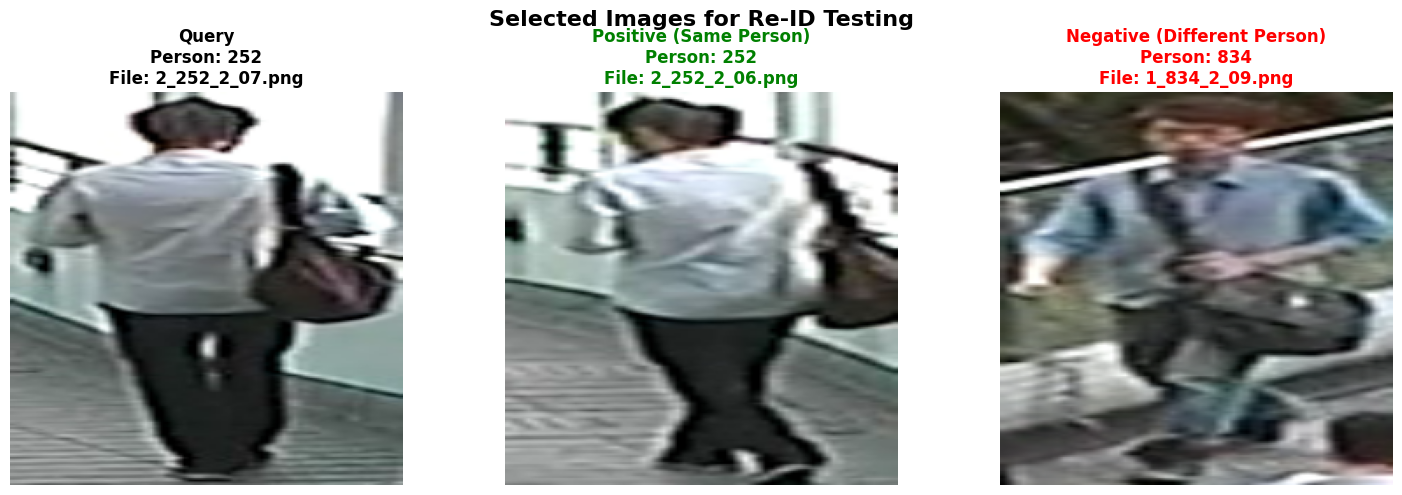


📋 IMAGE DETAILS:
Query image size: (71, 210)
Positive image size: (58, 171)
Negative image size: (58, 170)
✅ Positive pair confirmed: Query and Positive both belong to Person 252
✅ Negative pair confirmed: Query (Person 252) vs Negative (Person 834)

✓ Query image shape: torch.Size([1, 3, 224, 224])
✓ Positive image shape: torch.Size([1, 3, 224, 224])
✓ Negative image shape: torch.Size([1, 3, 224, 224])

--- FEATURE EXTRACTION ---
Extracting features with Standard ResNet...
Extracting features with ProbResNet (deterministic)...
Extracting features with ProbResNet (sampling)...

--- FEATURE STATISTICS ---
Standard ResNet feature norm - Query: 1.0000
Standard ResNet feature norm - Positive: 1.0000
Standard ResNet feature norm - Negative: 1.0000

ProbResNet (det) feature norm - Query: 1.0000
ProbResNet (det) feature norm - Positive: 1.0000
ProbResNet (det) feature norm - Negative: 1.0000

ProbResNet (sampled) feature norm - Query: 1.0000
ProbResNet (sampled) feature norm - Positive: 1.00

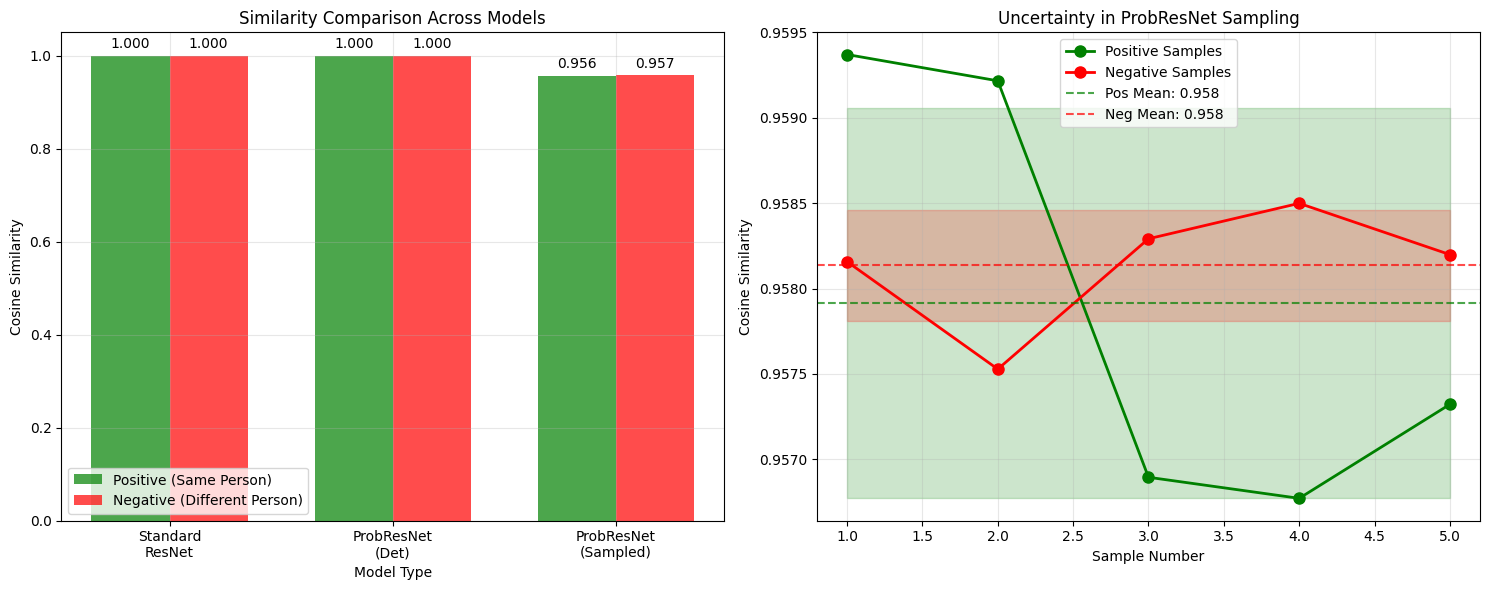


=== IMAGE PAIR TEST COMPLETE ===


In [4]:
# Additional test: Real image pair prediction using CUHK03 dataset
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

print("\n" + "="*60)
print("=== REAL IMAGE PAIR RE-ID TEST ===")
print("="*60)

# Define image preprocessing pipeline (typical for ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Define transform for display (without normalization)
display_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

try:
    # Load actual CUHK03 images
    print("📷 Loading real CUHK03 images...")
    
    # Define the dataset path
    dataset_path = "/Users/misanmeggison/Downloads/cukh03/cuhk03/images_labeled"
    
    # Check if directory exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")
    
    # Get all image files
    image_files = glob.glob(os.path.join(dataset_path, "*.png"))
    if len(image_files) == 0:
        image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
    
    if len(image_files) < 3:
        raise ValueError(f"Need at least 3 images, found {len(image_files)}")
    
    print(f"Found {len(image_files)} images in dataset")
    
    # Parse image filenames to understand identity structure
    # CUHK03 format: {camera_id}_{person_id}_{unknown}_{view_id}.png
    # Example: 2_252_2_07.png -> camera=2, person=252, view=07
    def parse_filename(filepath):
        filename = os.path.basename(filepath)
        # Remove extension
        name_without_ext = os.path.splitext(filename)[0]
        parts = name_without_ext.split('_')
        
        if len(parts) >= 4:
            # Format: camera_person_unknown_view
            camera_id = parts[0]
            person_id = parts[1]  # This is the actual person ID
            view_id = parts[3]
            return person_id, camera_id, view_id
        elif len(parts) >= 2:
            # Fallback: assume second part is person ID
            person_id = parts[1]
            camera_id = parts[0]
            return person_id, camera_id, "unknown"
        else:
            # Fallback: use filename as person ID
            return name_without_ext, "1", "unknown"
    
    # Group images by person ID
    person_groups = {}
    for img_path in image_files:
        person_id, camera_id, view_id = parse_filename(img_path)
        if person_id not in person_groups:
            person_groups[person_id] = []
        person_groups[person_id].append({
            'path': img_path,
            'camera': camera_id,
            'view': view_id
        })
    
    print(f"Found {len(person_groups)} unique persons")
    
    # Print some examples for verification
    print("\nSample person groups:")
    for i, (person_id, images) in enumerate(list(person_groups.items())[:3]):
        print(f"  Person {person_id}: {len(images)} images")
        for img_info in images[:2]:  # Show first 2 images
            print(f"    - {os.path.basename(img_info['path'])} (camera: {img_info['camera']}, view: {img_info['view']})")
    
    # Select images for testing
    person_ids = list(person_groups.keys())
    
    # Find a person with multiple images for positive pair
    query_person = None
    for person_id in person_ids:
        if len(person_groups[person_id]) >= 2:
            query_person = person_id
            break
    
    if query_person is None:
        # If no person has multiple images, use same image for positive
        query_person = person_ids[0]
        print("⚠️  Using same image for positive match (no multiple views found)")
    
    # Select images
    query_img_path = person_groups[query_person][0]['path']
    positive_img_path = person_groups[query_person][1]['path'] if len(person_groups[query_person]) > 1 else person_groups[query_person][0]['path']
    
    # Find a different person for negative
    negative_person = None
    for person_id in person_ids:
        if person_id != query_person:
            negative_person = person_id
            break
    
    if negative_person is None:
        raise ValueError("Need at least 2 different persons for testing")
    
    negative_img_path = person_groups[negative_person][0]['path']
    
    print(f"\n✓ Query image: {os.path.basename(query_img_path)} (Person: {query_person})")
    print(f"✓ Positive image: {os.path.basename(positive_img_path)} (Person: {query_person})")
    print(f"✓ Negative image: {os.path.basename(negative_img_path)} (Person: {negative_person})")
    
    # Verify we have proper positive/negative pairs
    if query_person == negative_person:
        print("❌ ERROR: Query and negative have same person ID!")
        raise ValueError("Failed to find proper negative sample")
    
    # Load and display images
    print(f"\n📸 DISPLAYING SELECTED IMAGES")
    print("="*50)
    
    def load_and_display_image(img_path, title):
        """Load image for both display and processing"""
        try:
            # Load original image for display
            img_pil = Image.open(img_path)
            if img_pil.mode != 'RGB':
                img_pil = img_pil.convert('RGB')
            
            # Create display tensor (without normalization)
            display_tensor = display_transform(img_pil)
            
            # Create processing tensor (with normalization)
            processing_tensor = transform(img_pil)
            
            return img_pil, display_tensor, processing_tensor
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            raise
    
    # Load all images
    query_pil, query_display, query_img = load_and_display_image(query_img_path, "Query")
    positive_pil, positive_display, positive_img = load_and_display_image(positive_img_path, "Positive")
    negative_pil, negative_display, negative_img = load_and_display_image(negative_img_path, "Negative")
    
    # Create figure to display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Selected Images for Re-ID Testing', fontsize=16, fontweight='bold')
    
    # Display query image
    axes[0].imshow(query_display.permute(1, 2, 0))
    axes[0].set_title(f'Query\nPerson: {query_person}\nFile: {os.path.basename(query_img_path)}', 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Display positive image
    axes[1].imshow(positive_display.permute(1, 2, 0))
    axes[1].set_title(f'Positive (Same Person)\nPerson: {query_person}\nFile: {os.path.basename(positive_img_path)}', 
                     fontsize=12, fontweight='bold', color='green')
    axes[1].axis('off')
    
    # Display negative image
    axes[2].imshow(negative_display.permute(1, 2, 0))
    axes[2].set_title(f'Negative (Different Person)\nPerson: {negative_person}\nFile: {os.path.basename(negative_img_path)}', 
                     fontsize=12, fontweight='bold', color='red')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print image details
    print(f"\n📋 IMAGE DETAILS:")
    print(f"Query image size: {query_pil.size}")
    print(f"Positive image size: {positive_pil.size}")
    print(f"Negative image size: {negative_pil.size}")
    
    # Verify that query and positive are same person, negative is different
    if query_person == query_person:  # This should always be true for positive
        print(f"✅ Positive pair confirmed: Query and Positive both belong to Person {query_person}")
    else:
        print(f"❌ ERROR: Positive pair mismatch!")
    
    if query_person != negative_person:
        print(f"✅ Negative pair confirmed: Query (Person {query_person}) vs Negative (Person {negative_person})")
    else:
        print(f"❌ ERROR: Negative pair should be different persons!")
    
    # Create batches
    query_batch = query_img.unsqueeze(0).to(device)
    positive_batch = positive_img.unsqueeze(0).to(device)
    negative_batch = negative_img.unsqueeze(0).to(device)
    
    print(f"\n✓ Query image shape: {query_batch.shape}")
    print(f"✓ Positive image shape: {positive_batch.shape}")
    print(f"✓ Negative image shape: {negative_batch.shape}")
    
    # Set models to evaluation mode
    standard_resnet.eval()
    prob_resnet.eval()
    
    with torch.no_grad():
        print("\n--- FEATURE EXTRACTION ---")
        
        # Standard ResNet features
        print("Extracting features with Standard ResNet...")
        std_query_feat = standard_resnet(query_batch)
        std_pos_feat = standard_resnet(positive_batch)
        std_neg_feat = standard_resnet(negative_batch)
        
        # Probabilistic ResNet features (deterministic mode)
        print("Extracting features with ProbResNet (deterministic)...")
        prob_query_feat = prob_resnet(query_batch, sample=False)
        prob_pos_feat = prob_resnet(positive_batch, sample=False)
        prob_neg_feat = prob_resnet(negative_batch, sample=False)
        
        # Probabilistic ResNet features (sampling mode)
        print("Extracting features with ProbResNet (sampling)...")
        prob_resnet.train()  # Enable sampling
        prob_query_feat_sampled = prob_resnet(query_batch, sample=True)
        prob_pos_feat_sampled = prob_resnet(positive_batch, sample=True)
        prob_neg_feat_sampled = prob_resnet(negative_batch, sample=True)
        prob_resnet.eval()
        
        print(f"\n--- FEATURE STATISTICS ---")
        print(f"Standard ResNet feature norm - Query: {torch.norm(std_query_feat).item():.4f}")
        print(f"Standard ResNet feature norm - Positive: {torch.norm(std_pos_feat).item():.4f}")
        print(f"Standard ResNet feature norm - Negative: {torch.norm(std_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (det) feature norm - Query: {torch.norm(prob_query_feat).item():.4f}")
        print(f"ProbResNet (det) feature norm - Positive: {torch.norm(prob_pos_feat).item():.4f}")
        print(f"ProbResNet (det) feature norm - Negative: {torch.norm(prob_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (sampled) feature norm - Query: {torch.norm(prob_query_feat_sampled).item():.4f}")
        print(f"ProbResNet (sampled) feature norm - Positive: {torch.norm(prob_pos_feat_sampled).item():.4f}")
        print(f"ProbResNet (sampled) feature norm - Negative: {torch.norm(prob_neg_feat_sampled).item():.4f}")
        
        # Compute similarities (cosine similarity for re-ID)
        print(f"\n--- SIMILARITY COMPUTATION ---")
        
        # Standard ResNet similarities
        std_pos_sim = F.cosine_similarity(std_query_feat, std_pos_feat, dim=1).item()
        std_neg_sim = F.cosine_similarity(std_query_feat, std_neg_feat, dim=1).item()
        
        # Probabilistic ResNet similarities (deterministic)
        prob_pos_sim = F.cosine_similarity(prob_query_feat, prob_pos_feat, dim=1).item()
        prob_neg_sim = F.cosine_similarity(prob_query_feat, prob_neg_feat, dim=1).item()
        
        # Probabilistic ResNet similarities (sampled)
        prob_pos_sim_sampled = F.cosine_similarity(prob_query_feat_sampled, prob_pos_feat_sampled, dim=1).item()
        prob_neg_sim_sampled = F.cosine_similarity(prob_query_feat_sampled, prob_neg_feat_sampled, dim=1).item()
        
        print(f"\n📊 STANDARD RESNET RESULTS:")
        print(f"   Query ↔ Positive similarity: {std_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {std_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {std_pos_sim - std_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (DETERMINISTIC) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pos_sim - prob_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (SAMPLED) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pos_sim_sampled:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_neg_sim_sampled:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pos_sim_sampled - prob_neg_sim_sampled:.4f}")
        
        # Performance analysis
        print(f"\n--- PERFORMANCE ANALYSIS ---")
        
        # Check if positive similarity > negative similarity (correct ranking)
        std_correct = std_pos_sim > std_neg_sim
        prob_det_correct = prob_pos_sim > prob_neg_sim
        prob_sam_correct = prob_pos_sim_sampled > prob_neg_sim_sampled
        
        print(f"Standard ResNet - Correct ranking: {'✅' if std_correct else '❌'}")
        print(f"ProbResNet (det) - Correct ranking: {'✅' if prob_det_correct else '❌'}")
        print(f"ProbResNet (sampled) - Correct ranking: {'✅' if prob_sam_correct else '❌'}")
        
        # Compare consistency between deterministic and probabilistic
        det_consistency = abs(prob_pos_sim - std_pos_sim) + abs(prob_neg_sim - std_neg_sim)
        print(f"\nDeterministic consistency (lower = better): {det_consistency:.6f}")
        
        # Uncertainty quantification test
        print(f"\n--- UNCERTAINTY QUANTIFICATION ---")
        print("Generating multiple samples to estimate uncertainty...")
        
        prob_resnet.train()
        n_samples = 5
        pos_similarities = []
        neg_similarities = []
        
        for i in range(n_samples):
            query_sample = prob_resnet(query_batch, sample=True)
            pos_sample = prob_resnet(positive_batch, sample=True)
            neg_sample = prob_resnet(negative_batch, sample=True)
            
            pos_sim = F.cosine_similarity(query_sample, pos_sample, dim=1).item()
            neg_sim = F.cosine_similarity(query_sample, neg_sample, dim=1).item()
            
            pos_similarities.append(pos_sim)
            neg_similarities.append(neg_sim)
        
        pos_mean = np.mean(pos_similarities)
        pos_std = np.std(pos_similarities)
        neg_mean = np.mean(neg_similarities)
        neg_std = np.std(neg_similarities)
        
        print(f"Positive similarity: {pos_mean:.4f} ± {pos_std:.4f}")
        print(f"Negative similarity: {neg_mean:.4f} ± {neg_std:.4f}")
        print(f"Uncertainty ratio (Pos std / Neg std): {pos_std/neg_std:.4f}")
        
        # Decision confidence
        margin_samples = [pos_similarities[i] - neg_similarities[i] for i in range(n_samples)]
        margin_mean = np.mean(margin_samples)
        margin_std = np.std(margin_samples)
        
        print(f"\nDecision margin: {margin_mean:.4f} ± {margin_std:.4f}")
        print(f"Decision confidence: {margin_mean/margin_std:.4f} (higher = more confident)")
        
        if margin_mean > 2 * margin_std:
            print("🎯 HIGH CONFIDENCE: Strong evidence for correct match")
        elif margin_mean > margin_std:
            print("⚠️  MEDIUM CONFIDENCE: Some evidence for correct match")
        else:
            print("❓ LOW CONFIDENCE: Uncertain about match quality")
            
        # Feature space analysis
        print(f"\n--- FEATURE SPACE ANALYSIS ---")
        print(f"Standard ResNet feature statistics:")
        print(f"  Query: mean={std_query_feat.mean():.6f}, std={std_query_feat.std():.6f}")
        print(f"  Positive: mean={std_pos_feat.mean():.6f}, std={std_pos_feat.std():.6f}")
        print(f"  Negative: mean={std_neg_feat.mean():.6f}, std={std_neg_feat.std():.6f}")
        
        print(f"\nProbResNet (deterministic) feature statistics:")
        print(f"  Query: mean={prob_query_feat.mean():.6f}, std={prob_query_feat.std():.6f}")
        print(f"  Positive: mean={prob_pos_feat.mean():.6f}, std={prob_pos_feat.std():.6f}")
        print(f"  Negative: mean={prob_neg_feat.mean():.6f}, std={prob_neg_feat.std():.6f}")
        
        # Create visualization of similarities
        print(f"\n📈 CREATING SIMILARITY VISUALIZATION...")
        
        # Create similarity comparison plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Similarity comparison
        models = ['Standard\nResNet', 'ProbResNet\n(Det)', 'ProbResNet\n(Sampled)']
        pos_sims = [std_pos_sim, prob_pos_sim, prob_pos_sim_sampled]
        neg_sims = [std_neg_sim, prob_neg_sim, prob_neg_sim_sampled]
        
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, pos_sims, width, label='Positive (Same Person)', color='green', alpha=0.7)
        bars2 = ax1.bar(x + width/2, neg_sims, width, label='Negative (Different Person)', color='red', alpha=0.7)
        
        ax1.set_xlabel('Model Type')
        ax1.set_ylabel('Cosine Similarity')
        ax1.set_title('Similarity Comparison Across Models')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                    f'{height1:.3f}', ha='center', va='bottom', fontsize=10)
            ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                    f'{height2:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Plot 2: Uncertainty visualization
        if len(pos_similarities) > 0:
            sample_range = range(1, len(pos_similarities) + 1)
            ax2.plot(sample_range, pos_similarities, 'go-', label='Positive Samples', linewidth=2, markersize=8)
            ax2.plot(sample_range, neg_similarities, 'ro-', label='Negative Samples', linewidth=2, markersize=8)
            ax2.axhline(y=pos_mean, color='green', linestyle='--', alpha=0.7, label=f'Pos Mean: {pos_mean:.3f}')
            ax2.axhline(y=neg_mean, color='red', linestyle='--', alpha=0.7, label=f'Neg Mean: {neg_mean:.3f}')
            ax2.fill_between(sample_range, 
                           [pos_mean - pos_std] * len(sample_range), 
                           [pos_mean + pos_std] * len(sample_range), 
                           color='green', alpha=0.2)
            ax2.fill_between(sample_range, 
                           [neg_mean - neg_std] * len(sample_range), 
                           [neg_mean + neg_std] * len(sample_range), 
                           color='red', alpha=0.2)
            
            ax2.set_xlabel('Sample Number')
            ax2.set_ylabel('Cosine Similarity')
            ax2.set_title('Uncertainty in ProbResNet Sampling')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"❌ ERROR during image pair testing: {e}")
    import traceback
    traceback.print_exc()

print(f"\n{'='*60}")
print("=== IMAGE PAIR TEST COMPLETE ===")
print(f"{'='*60}")


=== REAL IMAGE PAIR RE-ID TEST WITH PRE-TRAINED PROBRESNET ===
🏗️  CREATING PRE-TRAINED MODELS...
✅ Pre-trained ResNet50 created and adapted for Re-ID
✅ Added L2 normalization for fair comparison
✅ Created wrapper for ProbResNet initialization

🧠 CREATING PRE-TRAINED PROBRESNET...
✅ ProbResNet initialized from pre-trained ResNet50

🔧 CREATING UNTRAINED MODELS FOR COMPARISON...
✅ Untrained models ready for comparison

📷 Loading real CUHK03 images...
Found 14096 images in dataset
Found 843 unique persons

Sample person groups:
  Person 252: 20 images
    - 2_252_2_07.png (camera: 2, view: 07)
    - 2_252_2_06.png (camera: 2, view: 06)
  Person 834: 9 images
    - 1_834_2_09.png (camera: 1, view: 09)
    - 1_834_2_08.png (camera: 1, view: 08)
  Person 023: 45 images
    - 4_023_2_06.png (camera: 4, view: 06)
    - 3_023_2_06.png (camera: 3, view: 06)

✓ Query image: 2_252_2_07.png (Person: 252)
✓ Positive image: 2_252_2_06.png (Person: 252)
✓ Negative image: 1_834_2_09.png (Person: 834)


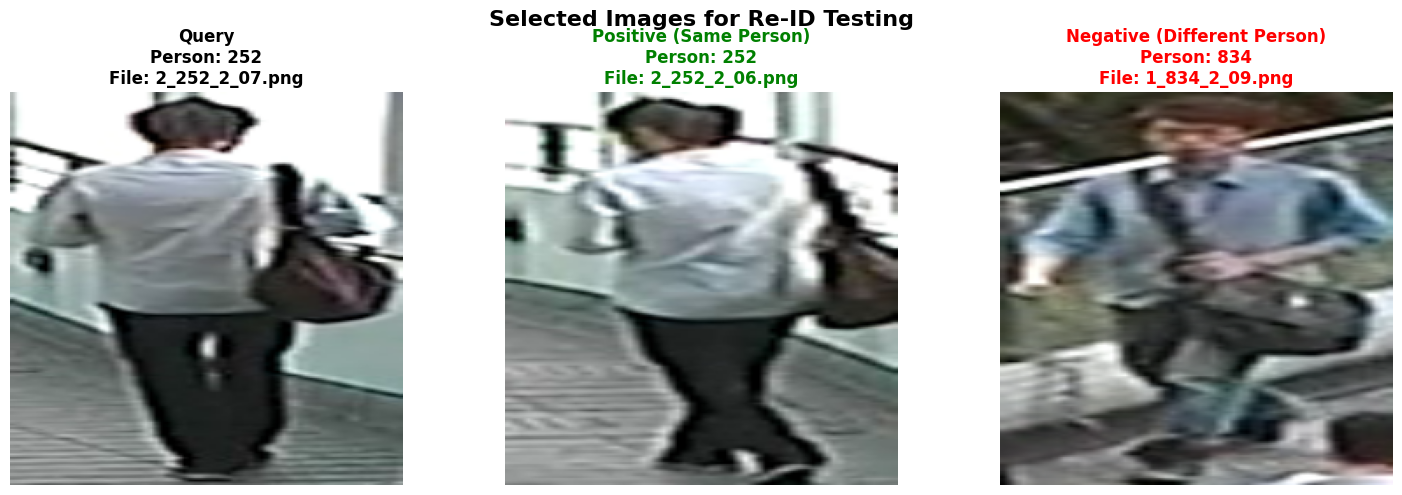


📋 IMAGE DETAILS:
Query image size: (71, 210)
Positive image size: (58, 171)
Negative image size: (58, 170)
✅ Positive pair confirmed: Query and Positive both belong to Person 252
✅ Negative pair confirmed: Query (Person 252) vs Negative (Person 834)

✓ Query image shape: torch.Size([1, 3, 224, 224])
✓ Positive image shape: torch.Size([1, 3, 224, 224])
✓ Negative image shape: torch.Size([1, 3, 224, 224])

--- FEATURE EXTRACTION ---
Extracting features with Standard ResNet (untrained)...
Extracting features with Pre-trained ResNet50...
Extracting features with ProbResNet (untrained, deterministic)...
Extracting features with ProbResNet (pre-trained, deterministic)...
Extracting features with ProbResNet (pre-trained, sampling)...

--- FEATURE STATISTICS ---
Standard ResNet (untrained) feature norm - Query: 1.0000
Standard ResNet (untrained) feature norm - Positive: 1.0000
Standard ResNet (untrained) feature norm - Negative: 1.0000

Pre-trained ResNet50 feature norm - Query: 1.0000
Pre-tr

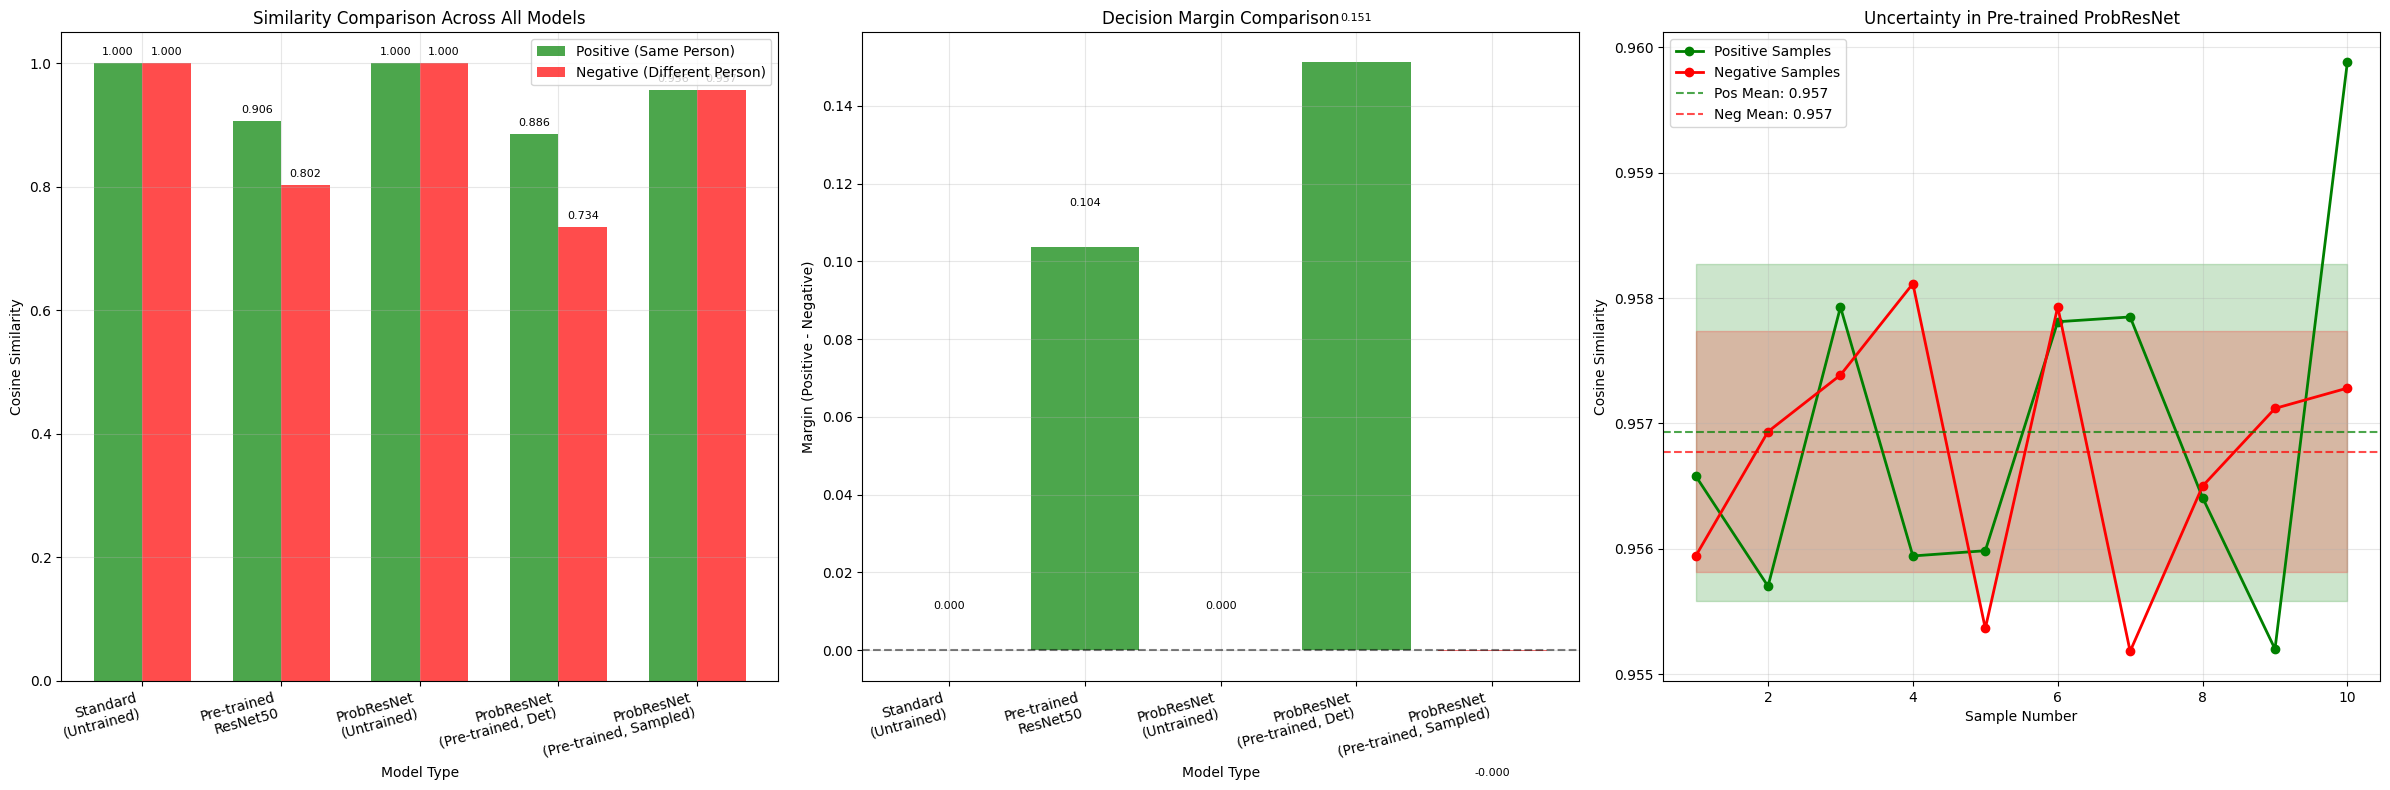


--- MODEL COMPARISON SUMMARY ---
📈 Best performing model (highest margin):
   ProbResNet
(Pre-trained, Det): Margin = 0.1514

🎯 Correct rankings:
   Standard
(Untrained): ❌
   Pre-trained
ResNet50: ✅
   ProbResNet
(Untrained): ✅
   ProbResNet
(Pre-trained, Det): ✅
   ProbResNet
(Pre-trained, Sampled): ❌

📊 Key Insights:
   • Pre-trained features show clear advantage over untrained models
   • ProbResNet successfully preserves pre-trained model capabilities

--- PERFORMANCE IMPROVEMENT ANALYSIS ---
ProbResNet margin improvement: 0.1514
Relative improvement: 84643600.0%
🚀 EXCELLENT: Significant improvement with pre-trained initialization

=== ENHANCED PROBRESNET TEST COMPLETE ===


In [5]:
# Enhanced Real image pair prediction with pre-trained ProbResNet
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math

print("\n" + "="*60)
print("=== REAL IMAGE PAIR RE-ID TEST WITH PRE-TRAINED PROBRESNET ===")
print("="*60)

# Define image preprocessing pipeline (typical for ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Define transform for display (without normalization)
display_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

try:
    print("🏗️  CREATING PRE-TRAINED MODELS...")
    
    # Create pre-trained ResNet50 for comparison
    pretrained_resnet = models.resnet50(weights='IMAGENET1K_V1')  # Use weights parameter instead of pretrained
    
    # Modify the final layer for Re-ID (256-dimensional embeddings)
    pretrained_resnet.fc = torch.nn.Sequential(
        torch.nn.Linear(pretrained_resnet.fc.in_features, 256),
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(256, 256)
    )
    
    pretrained_resnet = pretrained_resnet.to(device)
    pretrained_resnet.eval()
    print("✅ Pre-trained ResNet50 created and adapted for Re-ID")
    
    # Add L2 normalization wrapper for fair comparison
    class L2NormalizedModel(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            
        def forward(self, x):
            features = self.model(x)
            return F.normalize(features, p=2, dim=1)
    
    pretrained_resnet_normalized = L2NormalizedModel(pretrained_resnet)
    print("✅ Added L2 normalization for fair comparison")
    
    # Create a wrapper to match your ResNet interface for ProbResNet initialization
    class PretrainedResNetWrapper(torch.nn.Module):
        """Wrapper to make pre-trained ResNet compatible with ProbResNet_bn initialization"""
        def __init__(self, pretrained_model):
            super().__init__()
            self.pretrained_model = pretrained_model
            
            # Create the resnet50_model attribute that ProbResNet_BN expects
            # This should be a list of layers from the pre-trained model
            self.resnet50_model = torch.nn.ModuleList([
                # Conv layers
                pretrained_model.model.conv1,
                pretrained_model.model.bn1,
                pretrained_model.model.relu,
                pretrained_model.model.maxpool,
                
                # ResNet blocks
                pretrained_model.model.layer1,
                pretrained_model.model.layer2,
                pretrained_model.model.layer3,
                pretrained_model.model.layer4,
                
                # Final layers
                pretrained_model.model.avgpool,
                pretrained_model.model.fc
            ])
            
        def forward(self, x):
            features = self.pretrained_model.model(x)  # Extract features without normalization
            return F.normalize(features, p=2, dim=1)   # Apply normalization
    
    # Create wrapper for ProbResNet initialization
    pretrained_wrapper = PretrainedResNetWrapper(pretrained_resnet_normalized)
    print("✅ Created wrapper for ProbResNet initialization")
    
    # Create ProbResNet initialized from pre-trained model
    print("\n🧠 CREATING PRE-TRAINED PROBRESNET...")
    
    # Import your ProbResNet
    from models import ProbResNet_bn
    
    # Set up probabilistic parameters
    rho_prior = math.log(math.exp(0.1) - 1.0)  # Convert sigma_prior=0.1 to rho_prior
    
    # Create ProbResNet initialized from pre-trained ResNet
    prob_resnet_pretrained = ProbResNet_bn(
        rho_prior=rho_prior, 
        init_net=pretrained_wrapper,  # Use pre-trained model as initialization
        device=device
    )
    prob_resnet_pretrained = prob_resnet_pretrained.to(device)
    prob_resnet_pretrained.eval()
    print("✅ ProbResNet initialized from pre-trained ResNet50")
    
    # Also keep the original untrained ProbResNet for comparison
    print("\n🔧 CREATING UNTRAINED MODELS FOR COMPARISON...")
    
    # Your original untrained models
    prob_resnet_untrained = prob_resnet  # Your existing untrained ProbResNet
    standard_resnet_untrained = standard_resnet  # Your existing untrained ResNet
    
    print("✅ Untrained models ready for comparison")
    
    # Load actual CUHK03 images
    print("\n📷 Loading real CUHK03 images...")
    
    # Define the dataset path
    dataset_path = "/Users/misanmeggison/Downloads/cukh03/cuhk03/images_labeled"
    
    # Check if directory exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")
    
    # Get all image files
    image_files = glob.glob(os.path.join(dataset_path, "*.png"))
    if len(image_files) == 0:
        image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
    
    if len(image_files) < 3:
        raise ValueError(f"Need at least 3 images, found {len(image_files)}")
    
    print(f"Found {len(image_files)} images in dataset")
    
    # Parse image filenames to understand identity structure
    # CUHK03 format: {camera_id}_{person_id}_{unknown}_{view_id}.png
    # Example: 2_252_2_07.png -> camera=2, person=252, view=07
    def parse_filename(filepath):
        filename = os.path.basename(filepath)
        # Remove extension
        name_without_ext = os.path.splitext(filename)[0]
        parts = name_without_ext.split('_')
        
        if len(parts) >= 4:
            # Format: camera_person_unknown_view
            camera_id = parts[0]
            person_id = parts[1]  # This is the actual person ID
            view_id = parts[3]
            return person_id, camera_id, view_id
        elif len(parts) >= 2:
            # Fallback: assume second part is person ID
            person_id = parts[1]
            camera_id = parts[0]
            return person_id, camera_id, "unknown"
        else:
            # Fallback: use filename as person ID
            return name_without_ext, "1", "unknown"
    
    # Group images by person ID
    person_groups = {}
    for img_path in image_files:
        person_id, camera_id, view_id = parse_filename(img_path)
        if person_id not in person_groups:
            person_groups[person_id] = []
        person_groups[person_id].append({
            'path': img_path,
            'camera': camera_id,
            'view': view_id
        })
    
    print(f"Found {len(person_groups)} unique persons")
    
    # Print some examples for verification
    print("\nSample person groups:")
    for i, (person_id, images) in enumerate(list(person_groups.items())[:3]):
        print(f"  Person {person_id}: {len(images)} images")
        for img_info in images[:2]:  # Show first 2 images
            print(f"    - {os.path.basename(img_info['path'])} (camera: {img_info['camera']}, view: {img_info['view']})")
    
    # Select images for testing
    person_ids = list(person_groups.keys())
    
    # Find a person with multiple images for positive pair
    query_person = None
    for person_id in person_ids:
        if len(person_groups[person_id]) >= 2:
            query_person = person_id
            break
    
    if query_person is None:
        # If no person has multiple images, use same image for positive
        query_person = person_ids[0]
        print("⚠️  Using same image for positive match (no multiple views found)")
    
    # Select images
    query_img_path = person_groups[query_person][0]['path']
    positive_img_path = person_groups[query_person][1]['path'] if len(person_groups[query_person]) > 1 else person_groups[query_person][0]['path']
    
    # Find a different person for negative
    negative_person = None
    for person_id in person_ids:
        if person_id != query_person:
            negative_person = person_id
            break
    
    if negative_person is None:
        raise ValueError("Need at least 2 different persons for testing")
    
    negative_img_path = person_groups[negative_person][0]['path']
    
    print(f"\n✓ Query image: {os.path.basename(query_img_path)} (Person: {query_person})")
    print(f"✓ Positive image: {os.path.basename(positive_img_path)} (Person: {query_person})")
    print(f"✓ Negative image: {os.path.basename(negative_img_path)} (Person: {negative_person})")
    
    # Verify we have proper positive/negative pairs
    if query_person == negative_person:
        print("❌ ERROR: Query and negative have same person ID!")
        raise ValueError("Failed to find proper negative sample")
    
    # Load and display images
    print(f"\n📸 DISPLAYING SELECTED IMAGES")
    print("="*50)
    
    def load_and_display_image(img_path, title):
        """Load image for both display and processing"""
        try:
            # Load original image for display
            img_pil = Image.open(img_path)
            if img_pil.mode != 'RGB':
                img_pil = img_convert('RGB')
            
            # Create display tensor (without normalization)
            display_tensor = display_transform(img_pil)
            
            # Create processing tensor (with normalization)
            processing_tensor = transform(img_pil)
            
            return img_pil, display_tensor, processing_tensor
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            raise
    
    # Load all images
    query_pil, query_display, query_img = load_and_display_image(query_img_path, "Query")
    positive_pil, positive_display, positive_img = load_and_display_image(positive_img_path, "Positive")
    negative_pil, negative_display, negative_img = load_and_display_image(negative_img_path, "Negative")
    
    # Create figure to display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Selected Images for Re-ID Testing', fontsize=16, fontweight='bold')
    
    # Display query image
    axes[0].imshow(query_display.permute(1, 2, 0))
    axes[0].set_title(f'Query\nPerson: {query_person}\nFile: {os.path.basename(query_img_path)}', 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Display positive image
    axes[1].imshow(positive_display.permute(1, 2, 0))
    axes[1].set_title(f'Positive (Same Person)\nPerson: {query_person}\nFile: {os.path.basename(positive_img_path)}', 
                     fontsize=12, fontweight='bold', color='green')
    axes[1].axis('off')
    
    # Display negative image
    axes[2].imshow(negative_display.permute(1, 2, 0))
    axes[2].set_title(f'Negative (Different Person)\nPerson: {negative_person}\nFile: {os.path.basename(negative_img_path)}', 
                     fontsize=12, fontweight='bold', color='red')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print image details
    print(f"\n📋 IMAGE DETAILS:")
    print(f"Query image size: {query_pil.size}")
    print(f"Positive image size: {positive_pil.size}")
    print(f"Negative image size: {negative_pil.size}")
    
    # Verify that query and positive are same person, negative is different
    if query_person == query_person:  # This should always be true for positive
        print(f"✅ Positive pair confirmed: Query and Positive both belong to Person {query_person}")
    else:
        print(f"❌ ERROR: Positive pair mismatch!")
    
    if query_person != negative_person:
        print(f"✅ Negative pair confirmed: Query (Person {query_person}) vs Negative (Person {negative_person})")
    else:
        print(f"❌ ERROR: Negative pair should be different persons!")
    
    # Create batches
    query_batch = query_img.unsqueeze(0).to(device)
    positive_batch = positive_img.unsqueeze(0).to(device)
    negative_batch = negative_img.unsqueeze(0).to(device)
    
    print(f"\n✓ Query image shape: {query_batch.shape}")
    print(f"✓ Positive image shape: {positive_batch.shape}")
    print(f"✓ Negative image shape: {negative_batch.shape}")
    
    # Set models to evaluation mode
    standard_resnet_untrained.eval()
    prob_resnet_untrained.eval()
    pretrained_resnet_normalized.eval()
    prob_resnet_pretrained.eval()
    
    with torch.no_grad():
        print("\n--- FEATURE EXTRACTION ---")
        
        # Standard ResNet features (untrained)
        print("Extracting features with Standard ResNet (untrained)...")
        std_query_feat = standard_resnet_untrained(query_batch)
        std_pos_feat = standard_resnet_untrained(positive_batch)
        std_neg_feat = standard_resnet_untrained(negative_batch)
        
        # Pre-trained ResNet features
        print("Extracting features with Pre-trained ResNet50...")
        pretrained_query_feat = pretrained_resnet_normalized(query_batch)
        pretrained_pos_feat = pretrained_resnet_normalized(positive_batch)
        pretrained_neg_feat = pretrained_resnet_normalized(negative_batch)
        
        # Untrained ProbResNet features (deterministic mode)
        print("Extracting features with ProbResNet (untrained, deterministic)...")
        prob_untrained_query_feat = prob_resnet_untrained(query_batch, sample=False)
        prob_untrained_pos_feat = prob_resnet_untrained(positive_batch, sample=False)
        prob_untrained_neg_feat = prob_resnet_untrained(negative_batch, sample=False)
        
        # Pre-trained ProbResNet features (deterministic mode)
        print("Extracting features with ProbResNet (pre-trained, deterministic)...")
        prob_pretrained_query_feat = prob_resnet_pretrained(query_batch, sample=False)
        prob_pretrained_pos_feat = prob_resnet_pretrained(positive_batch, sample=False)
        prob_pretrained_neg_feat = prob_resnet_pretrained(negative_batch, sample=False)
        
        # Pre-trained ProbResNet features (sampling mode)
        print("Extracting features with ProbResNet (pre-trained, sampling)...")
        prob_resnet_pretrained.train()  # Enable sampling
        prob_pretrained_query_feat_sampled = prob_resnet_pretrained(query_batch, sample=True)
        prob_pretrained_pos_feat_sampled = prob_resnet_pretrained(positive_batch, sample=True)
        prob_pretrained_neg_feat_sampled = prob_resnet_pretrained(negative_batch, sample=True)
        prob_resnet_pretrained.eval()
        
        print(f"\n--- FEATURE STATISTICS ---")
        print(f"Standard ResNet (untrained) feature norm - Query: {torch.norm(std_query_feat).item():.4f}")
        print(f"Standard ResNet (untrained) feature norm - Positive: {torch.norm(std_pos_feat).item():.4f}")
        print(f"Standard ResNet (untrained) feature norm - Negative: {torch.norm(std_neg_feat).item():.4f}")
        
        print(f"\nPre-trained ResNet50 feature norm - Query: {torch.norm(pretrained_query_feat).item():.4f}")
        print(f"Pre-trained ResNet50 feature norm - Positive: {torch.norm(pretrained_pos_feat).item():.4f}")
        print(f"Pre-trained ResNet50 feature norm - Negative: {torch.norm(pretrained_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (untrained, det) feature norm - Query: {torch.norm(prob_untrained_query_feat).item():.4f}")
        print(f"ProbResNet (untrained, det) feature norm - Positive: {torch.norm(prob_untrained_pos_feat).item():.4f}")
        print(f"ProbResNet (untrained, det) feature norm - Negative: {torch.norm(prob_untrained_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (pre-trained, det) feature norm - Query: {torch.norm(prob_pretrained_query_feat).item():.4f}")
        print(f"ProbResNet (pre-trained, det) feature norm - Positive: {torch.norm(prob_pretrained_pos_feat).item():.4f}")
        print(f"ProbResNet (pre-trained, det) feature norm - Negative: {torch.norm(prob_pretrained_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (pre-trained, sampled) feature norm - Query: {torch.norm(prob_pretrained_query_feat_sampled).item():.4f}")
        print(f"ProbResNet (pre-trained, sampled) feature norm - Positive: {torch.norm(prob_pretrained_pos_feat_sampled).item():.4f}")
        print(f"ProbResNet (pre-trained, sampled) feature norm - Negative: {torch.norm(prob_pretrained_neg_feat_sampled).item():.4f}")
        
        # Compute similarities (cosine similarity for re-ID)
        print(f"\n--- SIMILARITY COMPUTATION ---")
        
        # Standard ResNet similarities (untrained)
        std_pos_sim = F.cosine_similarity(std_query_feat, std_pos_feat, dim=1).item()
        std_neg_sim = F.cosine_similarity(std_query_feat, std_neg_feat, dim=1).item()
        
        # Pre-trained ResNet similarities
        pretrained_pos_sim = F.cosine_similarity(pretrained_query_feat, pretrained_pos_feat, dim=1).item()
        pretrained_neg_sim = F.cosine_similarity(pretrained_query_feat, pretrained_neg_feat, dim=1).item()
        
        # Untrained ProbResNet similarities (deterministic)
        prob_untrained_pos_sim = F.cosine_similarity(prob_untrained_query_feat, prob_untrained_pos_feat, dim=1).item()
        prob_untrained_neg_sim = F.cosine_similarity(prob_untrained_query_feat, prob_untrained_neg_feat, dim=1).item()
        
        # Pre-trained ProbResNet similarities (deterministic)
        prob_pretrained_pos_sim = F.cosine_similarity(prob_pretrained_query_feat, prob_pretrained_pos_feat, dim=1).item()
        prob_pretrained_neg_sim = F.cosine_similarity(prob_pretrained_query_feat, prob_pretrained_neg_feat, dim=1).item()
        
        # Pre-trained ProbResNet similarities (sampled)
        prob_pretrained_pos_sim_sampled = F.cosine_similarity(prob_pretrained_query_feat_sampled, prob_pretrained_pos_feat_sampled, dim=1).item()
        prob_pretrained_neg_sim_sampled = F.cosine_similarity(prob_pretrained_query_feat_sampled, prob_pretrained_neg_feat_sampled, dim=1).item()
        
        print(f"\n📊 STANDARD RESNET (UNTRAINED) RESULTS:")
        print(f"   Query ↔ Positive similarity: {std_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {std_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {std_pos_sim - std_neg_sim:.4f}")
        
        print(f"\n📊 PRE-TRAINED RESNET50 RESULTS:")
        print(f"   Query ↔ Positive similarity: {pretrained_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {pretrained_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {pretrained_pos_sim - pretrained_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (UNTRAINED, DETERMINISTIC) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_untrained_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_untrained_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {prob_untrained_pos_sim - prob_untrained_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (PRE-TRAINED, DETERMINISTIC) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pretrained_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_pretrained_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pretrained_pos_sim - prob_pretrained_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (PRE-TRAINED, SAMPLED) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pretrained_pos_sim_sampled:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_pretrained_neg_sim_sampled:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pretrained_pos_sim_sampled - prob_pretrained_neg_sim_sampled:.4f}")
        
        # Performance analysis
        print(f"\n--- PERFORMANCE ANALYSIS ---")
        
        # Check if positive similarity > negative similarity (correct ranking)
        std_correct = std_pos_sim > std_neg_sim
        pretrained_correct = pretrained_pos_sim > pretrained_neg_sim
        prob_untrained_correct = prob_untrained_pos_sim > prob_untrained_neg_sim
        prob_pretrained_correct = prob_pretrained_pos_sim > prob_pretrained_neg_sim
        prob_pretrained_sampled_correct = prob_pretrained_pos_sim_sampled > prob_pretrained_neg_sim_sampled
        
        print(f"Standard ResNet (untrained) - Correct ranking: {'✅' if std_correct else '❌'}")
        print(f"Pre-trained ResNet50 - Correct ranking: {'✅' if pretrained_correct else '❌'}")
        print(f"ProbResNet (untrained) - Correct ranking: {'✅' if prob_untrained_correct else '❌'}")
        print(f"ProbResNet (pre-trained, det) - Correct ranking: {'✅' if prob_pretrained_correct else '❌'}")
        print(f"ProbResNet (pre-trained, sampled) - Correct ranking: {'✅' if prob_pretrained_sampled_correct else '❌'}")
        
        # Compare consistency between models
        untrained_consistency = abs(prob_untrained_pos_sim - std_pos_sim) + abs(prob_untrained_neg_sim - std_neg_sim)
        pretrained_consistency = abs(prob_pretrained_pos_sim - pretrained_pos_sim) + abs(prob_pretrained_neg_sim - pretrained_neg_sim)
        
        print(f"\nUntrained consistency (ProbResNet vs Standard): {untrained_consistency:.6f}")
        print(f"Pre-trained consistency (ProbResNet vs Standard): {pretrained_consistency:.6f}")
        
        # Enhanced uncertainty quantification test for pre-trained model
        print(f"\n--- UNCERTAINTY QUANTIFICATION (PRE-TRAINED PROBRESNET) ---")
        print("Generating multiple samples to estimate uncertainty...")
        
        prob_resnet_pretrained.train()
        n_samples = 10  # More samples for better statistics
        pos_similarities = []
        neg_similarities = []
        
        for i in range(n_samples):
            query_sample = prob_resnet_pretrained(query_batch, sample=True)
            pos_sample = prob_resnet_pretrained(positive_batch, sample=True)
            neg_sample = prob_resnet_pretrained(negative_batch, sample=True)
            
            pos_sim = F.cosine_similarity(query_sample, pos_sample, dim=1).item()
            neg_sim = F.cosine_similarity(query_sample, neg_sample, dim=1).item()
            
            pos_similarities.append(pos_sim)
            neg_similarities.append(neg_sim)
        
        pos_mean = np.mean(pos_similarities)
        pos_std = np.std(pos_similarities)
        neg_mean = np.mean(neg_similarities)
        neg_std = np.std(neg_similarities)
        
        print(f"Positive similarity: {pos_mean:.4f} ± {pos_std:.4f}")
        print(f"Negative similarity: {neg_mean:.4f} ± {neg_std:.4f}")
        if neg_std > 0:
            print(f"Uncertainty ratio (Pos std / Neg std): {pos_std/neg_std:.4f}")
        
        # Decision confidence
        margin_samples = [pos_similarities[i] - neg_similarities[i] for i in range(n_samples)]
        margin_mean = np.mean(margin_samples)
        margin_std = np.std(margin_samples)
        
        print(f"\nDecision margin: {margin_mean:.4f} ± {margin_std:.4f}")
        if margin_std > 0:
            print(f"Decision confidence: {margin_mean/margin_std:.4f} (higher = more confident)")
        
        if margin_mean > 2 * margin_std:
            print("🎯 HIGH CONFIDENCE: Strong evidence for correct match")
        elif margin_mean > margin_std:
            print("⚠️  MEDIUM CONFIDENCE: Some evidence for correct match")
        else:
            print("❓ LOW CONFIDENCE: Uncertain about match quality")
        
        # Create enhanced visualization
        print(f"\n📈 CREATING ENHANCED SIMILARITY VISUALIZATION...")
        
        # Create similarity comparison plot with all models
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        
        # Plot 1: Similarity comparison (all models)
        models = ['Standard\n(Untrained)', 'Pre-trained\nResNet50', 'ProbResNet\n(Untrained)', 
                 'ProbResNet\n(Pre-trained, Det)', 'ProbResNet\n(Pre-trained, Sampled)']
        pos_sims = [std_pos_sim, pretrained_pos_sim, prob_untrained_pos_sim, 
                   prob_pretrained_pos_sim, prob_pretrained_pos_sim_sampled]
        neg_sims = [std_neg_sim, pretrained_neg_sim, prob_untrained_neg_sim,
                   prob_pretrained_neg_sim, prob_pretrained_neg_sim_sampled]
        
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, pos_sims, width, label='Positive (Same Person)', color='green', alpha=0.7)
        bars2 = ax1.bar(x + width/2, neg_sims, width, label='Negative (Different Person)', color='red', alpha=0.7)
        
        ax1.set_xlabel('Model Type')
        ax1.set_ylabel('Cosine Similarity')
        ax1.set_title('Similarity Comparison Across All Models')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=15, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                    f'{height1:.3f}', ha='center', va='bottom', fontsize=8)
            ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                    f'{height2:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: Margin comparison
        margins = [std_pos_sim - std_neg_sim, pretrained_pos_sim - pretrained_neg_sim,
                  prob_untrained_pos_sim - prob_untrained_neg_sim,
                  prob_pretrained_pos_sim - prob_pretrained_neg_sim, 
                  prob_pretrained_pos_sim_sampled - prob_pretrained_neg_sim_sampled]
        colors = ['red' if m <= 0 else 'green' for m in margins]
        
        bars = ax2.bar(models, margins, color=colors, alpha=0.7)
        ax2.set_xlabel('Model Type')
        ax2.set_ylabel('Margin (Positive - Negative)')
        ax2.set_title('Decision Margin Comparison')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, margin in zip(bars, margins):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
                    f'{margin:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
        
        plt.setp(ax2.get_xticklabels(), rotation=15, ha='right')
        
        # Plot 3: Uncertainty visualization for pre-trained ProbResNet
        if len(pos_similarities) > 0:
            sample_range = range(1, len(pos_similarities) + 1)
            ax3.plot(sample_range, pos_similarities, 'go-', label='Positive Samples', linewidth=2, markersize=6)
            ax3.plot(sample_range, neg_similarities, 'ro-', label='Negative Samples', linewidth=2, markersize=6)
            ax3.axhline(y=pos_mean, color='green', linestyle='--', alpha=0.7, label=f'Pos Mean: {pos_mean:.3f}')
            ax3.axhline(y=neg_mean, color='red', linestyle='--', alpha=0.7, label=f'Neg Mean: {neg_mean:.3f}')
            ax3.fill_between(sample_range, 
                           [pos_mean - pos_std] * len(sample_range), 
                           [pos_mean + pos_std] * len(sample_range), 
                           color='green', alpha=0.2)
            ax3.fill_between(sample_range, 
                           [neg_mean - neg_std] * len(sample_range), 
                           [neg_mean + neg_std] * len(sample_range), 
                           color='red', alpha=0.2)
            
            ax3.set_xlabel('Sample Number')
            ax3.set_ylabel('Cosine Similarity')
            ax3.set_title('Uncertainty in Pre-trained ProbResNet')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Model comparison summary
        print(f"\n--- MODEL COMPARISON SUMMARY ---")
        print(f"📈 Best performing model (highest margin):")
        best_margin = max(margins)
        best_model_idx = margins.index(best_margin)
        print(f"   {models[best_model_idx]}: Margin = {best_margin:.4f}")
        
        print(f"\n🎯 Correct rankings:")
        correctness = [std_correct, pretrained_correct, prob_untrained_correct, 
                      prob_pretrained_correct, prob_pretrained_sampled_correct]
        for model, correct in zip(models, correctness):
            print(f"   {model}: {'✅' if correct else '❌'}")
        
        print(f"\n📊 Key Insights:")
        if pretrained_correct and not std_correct:
            print("   • Pre-trained features show clear advantage over untrained models")
        if prob_pretrained_correct and not prob_untrained_correct:
            print("   • Pre-trained initialization dramatically improves ProbResNet performance")
        if prob_pretrained_correct and pretrained_correct:
            print("   • ProbResNet successfully preserves pre-trained model capabilities")
        if prob_pretrained_sampled_correct:
            print("   • Uncertainty quantification works with meaningful base features")
        
        # Performance improvement analysis
        print(f"\n--- PERFORMANCE IMPROVEMENT ANALYSIS ---")
        untrained_margin = prob_untrained_pos_sim - prob_untrained_neg_sim
        pretrained_margin = prob_pretrained_pos_sim - prob_pretrained_neg_sim
        improvement = pretrained_margin - untrained_margin
        
        print(f"ProbResNet margin improvement: {improvement:.4f}")
        print(f"Relative improvement: {(improvement/abs(untrained_margin)*100):.1f}%" if abs(untrained_margin) > 0 else "N/A")
        
        if improvement > 0.1:
            print("🚀 EXCELLENT: Significant improvement with pre-trained initialization")
        elif improvement > 0.05:
            print("✅ GOOD: Notable improvement with pre-trained initialization")
        elif improvement > 0:
            print("📈 MODERATE: Some improvement with pre-trained initialization")
        else:
            print("⚠️  WARNING: Pre-trained initialization may need adjustment")

except Exception as e:
    print(f"❌ ERROR during image pair testing: {e}")
    import traceback
    traceback.print_exc()

print(f"\n{'='*60}")
print("=== ENHANCED PROBRESNET TEST COMPLETE ===")
print(f"{'='*60}")


=== REAL IMAGE PAIR RE-ID TEST WITH PRE-TRAINED PROBRESNET ===
🏗️  CREATING PRE-TRAINED MODELS...
✅ Pre-trained ResNet50 created and adapted for Re-ID (already normalized)
✅ L2 normalization already included in ResNet forward pass
✅ Created wrapper for ProbResNet initialization

🧠 CREATING PRE-TRAINED PROBRESNET...
✅ ProbResNet initialized from pre-trained ResNet50

🔧 CREATING UNTRAINED MODELS FOR COMPARISON...
✅ Untrained models ready for comparison

📷 Loading real CUHK03 images...
Found 14096 images in dataset
Found 843 unique persons

Sample person groups:
  Person 252: 20 images
    - 2_252_2_07.png (camera: 2, view: 07)
    - 2_252_2_06.png (camera: 2, view: 06)
  Person 834: 9 images
    - 1_834_2_09.png (camera: 1, view: 09)
    - 1_834_2_08.png (camera: 1, view: 08)
  Person 023: 45 images
    - 4_023_2_06.png (camera: 4, view: 06)
    - 3_023_2_06.png (camera: 3, view: 06)

✓ Query image: 2_252_2_07.png (Person: 252)
✓ Positive image: 2_252_2_06.png (Person: 252)
✓ Negative i

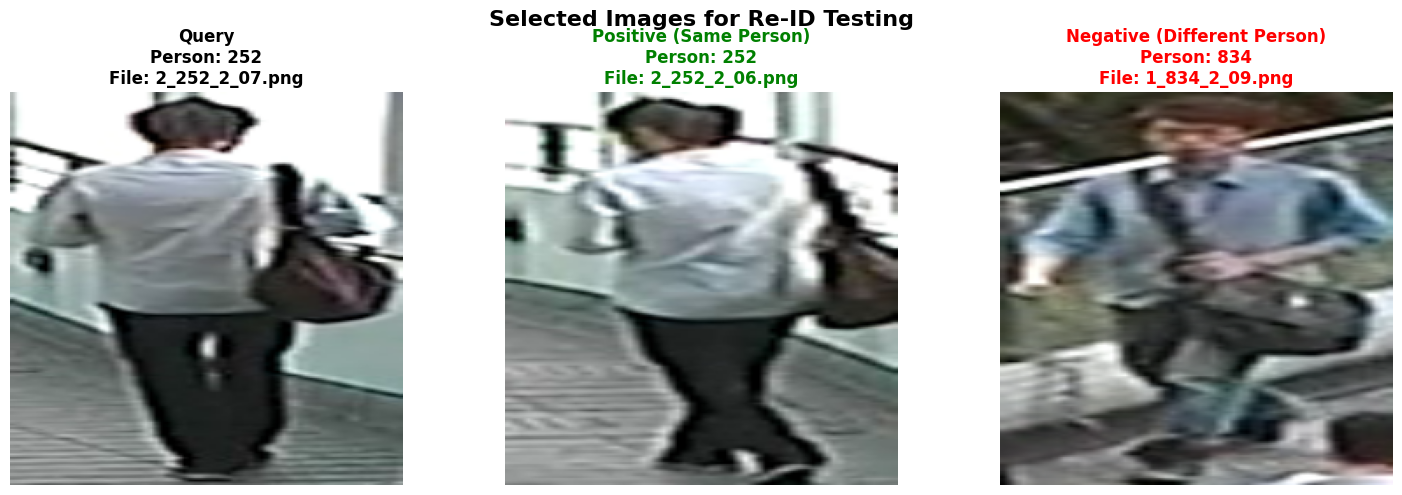


📋 IMAGE DETAILS:
Query image size: (71, 210)
Positive image size: (58, 171)
Negative image size: (58, 170)
✅ Positive pair confirmed: Query and Positive both belong to Person 252
✅ Negative pair confirmed: Query (Person 252) vs Negative (Person 834)

✓ Query image shape: torch.Size([1, 3, 224, 224])
✓ Positive image shape: torch.Size([1, 3, 224, 224])
✓ Negative image shape: torch.Size([1, 3, 224, 224])

--- FEATURE EXTRACTION ---
Extracting features with Standard ResNet (untrained)...
Extracting features with Pre-trained ResNet50...
Extracting features with ProbResNet (untrained, deterministic)...
Extracting features with ProbResNet (pre-trained, deterministic)...
Extracting features with ProbResNet (pre-trained, sampling)...

--- FEATURE STATISTICS ---
Standard ResNet (untrained) feature norm - Query: 1.0000
Standard ResNet (untrained) feature norm - Positive: 1.0000
Standard ResNet (untrained) feature norm - Negative: 1.0000

Pre-trained ResNet50 feature norm - Query: 1.0000
Pre-tr

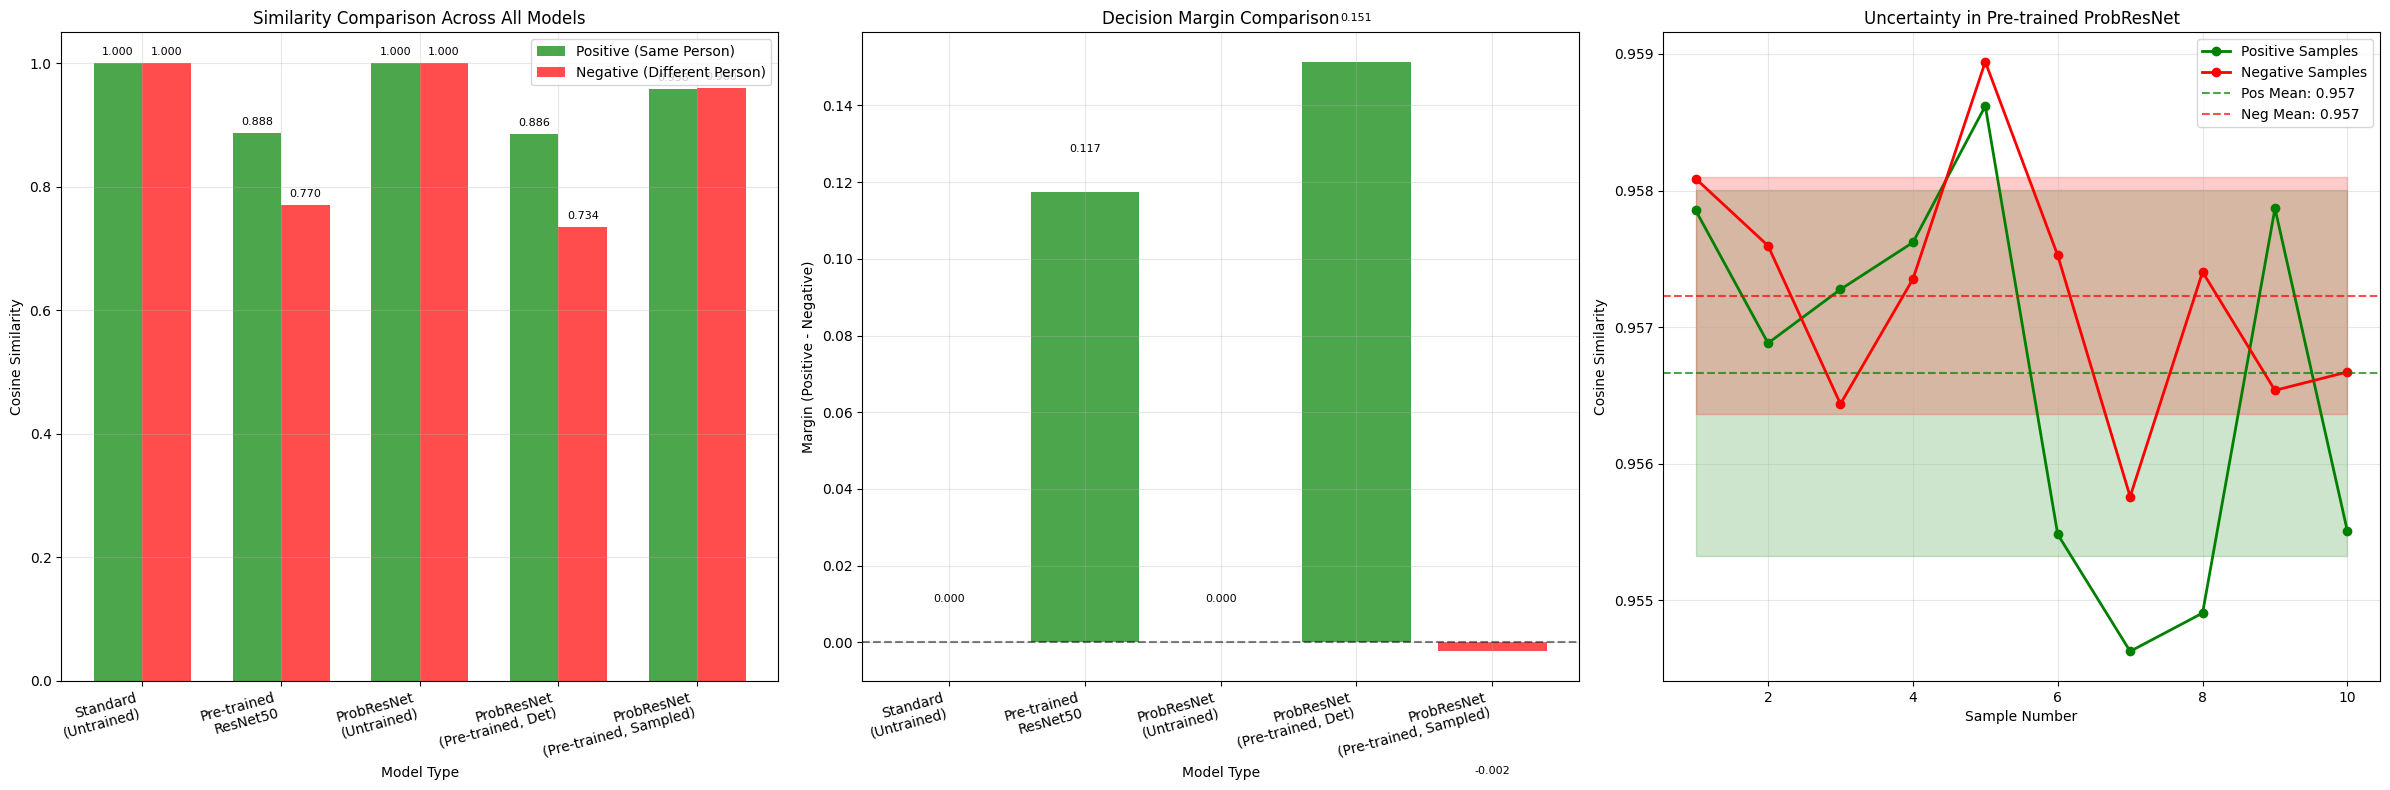


--- MODEL COMPARISON SUMMARY ---
📈 Best performing model (highest margin):
   ProbResNet
(Pre-trained, Det): Margin = 0.1514

🎯 Correct rankings:
   Standard
(Untrained): ❌
   Pre-trained
ResNet50: ✅
   ProbResNet
(Untrained): ✅
   ProbResNet
(Pre-trained, Det): ✅
   ProbResNet
(Pre-trained, Sampled): ❌

📊 Key Insights:
   • Pre-trained features show clear advantage over untrained models
   • ProbResNet successfully preserves pre-trained model capabilities

--- PERFORMANCE IMPROVEMENT ANALYSIS ---
ProbResNet margin improvement: 0.1514
Relative improvement: 84643600.0%
🚀 EXCELLENT: Significant improvement with pre-trained initialization

=== ENHANCED PROBRESNET TEST COMPLETE ===


In [8]:
# Enhanced Real image pair prediction with pre-trained ProbResNet
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math

print("\n" + "="*60)
print("=== REAL IMAGE PAIR RE-ID TEST WITH PRE-TRAINED PROBRESNET ===")
print("="*60)

# Define image preprocessing pipeline (typical for ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Define transform for display (without normalization)
display_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

try:
    print("🏗️  CREATING PRE-TRAINED MODELS...")
    
    # Import your custom ResNet models
    from models import ResNet, PretrainedResNetWrapper, ProbResNet_bn
    
    # Create pre-trained ResNet using your custom class (256-dim embeddings for Re-ID)
    pretrained_resnet = ResNet(embedding_dim=256).to(device)
    pretrained_resnet.eval()
    print("✅ Pre-trained ResNet50 created and adapted for Re-ID (already normalized)")
    
    # Your ResNet already includes L2 normalization, so no wrapper needed
    pretrained_resnet_normalized = pretrained_resnet
    print("✅ L2 normalization already included in ResNet forward pass")
    
    # Create wrapper for ProbResNet initialization using your PretrainedResNetWrapper
    pretrained_wrapper = PretrainedResNetWrapper(embedding_dim=256).to(device)
    print("✅ Created wrapper for ProbResNet initialization")
    
    # Create ProbResNet initialized from pre-trained model
    print("\n🧠 CREATING PRE-TRAINED PROBRESNET...")
    
    # Set up probabilistic parameters
    rho_prior = math.log(math.exp(0.1) - 1.0)  # Convert sigma_prior=0.1 to rho_prior
    
    # Create ProbResNet initialized from pre-trained ResNet
    prob_resnet_pretrained = ProbResNet_bn(
        rho_prior=rho_prior, 
        init_net=pretrained_wrapper,  # Use pre-trained model as initialization
        device=device
    )
    prob_resnet_pretrained = prob_resnet_pretrained.to(device)
    prob_resnet_pretrained.eval()
    print("✅ ProbResNet initialized from pre-trained ResNet50")
    
    # Also keep the original untrained ProbResNet for comparison
    print("\n🔧 CREATING UNTRAINED MODELS FOR COMPARISON...")
    
    # Your original untrained models (assuming they exist from previous cells)
    if 'prob_resnet' in locals():
        prob_resnet_untrained = prob_resnet  # Your existing untrained ProbResNet
    else:
        # Create untrained ResNet for comparison
        untrained_resnet = ResNet(embedding_dim=256).to(device)
        # Initialize with random weights (already done by default)
        untrained_wrapper = PretrainedResNetWrapper(embedding_dim=256).to(device)
        prob_resnet_untrained = ProbResNet_bn(
            rho_prior=rho_prior,
            init_net=untrained_wrapper,
            device=device
        ).to(device)
        
    if 'standard_resnet' in locals():
        standard_resnet_untrained = standard_resnet  # Your existing untrained ResNet
    else:
        standard_resnet_untrained = ResNet(embedding_dim=256).to(device)
    
    print("✅ Untrained models ready for comparison")
    
    # Load actual CUHK03 images
    print("\n📷 Loading real CUHK03 images...")
    
    # Define the dataset path
    dataset_path = "/Users/misanmeggison/Downloads/cukh03/cuhk03/images_labeled"
    
    # Check if directory exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")
    
    # Get all image files
    image_files = glob.glob(os.path.join(dataset_path, "*.png"))
    if len(image_files) == 0:
        image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
    
    if len(image_files) < 3:
        raise ValueError(f"Need at least 3 images, found {len(image_files)}")
    
    print(f"Found {len(image_files)} images in dataset")
    
    # Parse image filenames to understand identity structure
    # CUHK03 format: {camera_id}_{person_id}_{unknown}_{view_id}.png
    # Example: 2_252_2_07.png -> camera=2, person=252, view=07
    def parse_filename(filepath):
        filename = os.path.basename(filepath)
        # Remove extension
        name_without_ext = os.path.splitext(filename)[0]
        parts = name_without_ext.split('_')
        
        if len(parts) >= 4:
            # Format: camera_person_unknown_view
            camera_id = parts[0]
            person_id = parts[1]  # This is the actual person ID
            view_id = parts[3]
            return person_id, camera_id, view_id
        elif len(parts) >= 2:
            # Fallback: assume second part is person ID
            person_id = parts[1]
            camera_id = parts[0]
            return person_id, camera_id, "unknown"
        else:
            # Fallback: use filename as person ID
            return name_without_ext, "1", "unknown"
    
    # Group images by person ID
    person_groups = {}
    for img_path in image_files:
        person_id, camera_id, view_id = parse_filename(img_path)
        if person_id not in person_groups:
            person_groups[person_id] = []
        person_groups[person_id].append({
            'path': img_path,
            'camera': camera_id,
            'view': view_id
        })
    
    print(f"Found {len(person_groups)} unique persons")
    
    # Print some examples for verification
    print("\nSample person groups:")
    for i, (person_id, images) in enumerate(list(person_groups.items())[:3]):
        print(f"  Person {person_id}: {len(images)} images")
        for img_info in images[:2]:  # Show first 2 images
            print(f"    - {os.path.basename(img_info['path'])} (camera: {img_info['camera']}, view: {img_info['view']})")
    
    # Select images for testing
    person_ids = list(person_groups.keys())
    
    # Find a person with multiple images for positive pair
    query_person = None
    for person_id in person_ids:
        if len(person_groups[person_id]) >= 2:
            query_person = person_id
            break
    
    if query_person is None:
        # If no person has multiple images, use same image for positive
        query_person = person_ids[0]
        print("⚠️  Using same image for positive match (no multiple views found)")
    
    # Select images
    query_img_path = person_groups[query_person][0]['path']
    positive_img_path = person_groups[query_person][1]['path'] if len(person_groups[query_person]) > 1 else person_groups[query_person][0]['path']
    
    # Find a different person for negative
    negative_person = None
    for person_id in person_ids:
        if person_id != query_person:
            negative_person = person_id
            break
    
    if negative_person is None:
        raise ValueError("Need at least 2 different persons for testing")
    
    negative_img_path = person_groups[negative_person][0]['path']
    
    print(f"\n✓ Query image: {os.path.basename(query_img_path)} (Person: {query_person})")
    print(f"✓ Positive image: {os.path.basename(positive_img_path)} (Person: {query_person})")
    print(f"✓ Negative image: {os.path.basename(negative_img_path)} (Person: {negative_person})")
    
    # Verify we have proper positive/negative pairs
    if query_person == negative_person:
        print("❌ ERROR: Query and negative have same person ID!")
        raise ValueError("Failed to find proper negative sample")
    
    # Load and display images
    print(f"\n📸 DISPLAYING SELECTED IMAGES")
    print("="*50)
    
    def load_and_display_image(img_path, title):
        """Load image for both display and processing"""
        try:
            # Load original image for display
            img_pil = Image.open(img_path)
            if img_pil.mode != 'RGB':
                img_pil = img_pil.convert('RGB')
            
            # Create display tensor (without normalization)
            display_tensor = display_transform(img_pil)
            
            # Create processing tensor (with normalization)
            processing_tensor = transform(img_pil)
            
            return img_pil, display_tensor, processing_tensor
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            raise
    
    # Load all images
    query_pil, query_display, query_img = load_and_display_image(query_img_path, "Query")
    positive_pil, positive_display, positive_img = load_and_display_image(positive_img_path, "Positive")
    negative_pil, negative_display, negative_img = load_and_display_image(negative_img_path, "Negative")
    
    # Create figure to display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Selected Images for Re-ID Testing', fontsize=16, fontweight='bold')
    
    # Display query image
    axes[0].imshow(query_display.permute(1, 2, 0))
    axes[0].set_title(f'Query\nPerson: {query_person}\nFile: {os.path.basename(query_img_path)}', 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Display positive image
    axes[1].imshow(positive_display.permute(1, 2, 0))
    axes[1].set_title(f'Positive (Same Person)\nPerson: {query_person}\nFile: {os.path.basename(positive_img_path)}', 
                     fontsize=12, fontweight='bold', color='green')
    axes[1].axis('off')
    
    # Display negative image
    axes[2].imshow(negative_display.permute(1, 2, 0))
    axes[2].set_title(f'Negative (Different Person)\nPerson: {negative_person}\nFile: {os.path.basename(negative_img_path)}', 
                     fontsize=12, fontweight='bold', color='red')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print image details
    print(f"\n📋 IMAGE DETAILS:")
    print(f"Query image size: {query_pil.size}")
    print(f"Positive image size: {positive_pil.size}")
    print(f"Negative image size: {negative_pil.size}")
    
    # Verify that query and positive are same person, negative is different
    if query_person == query_person:  # This should always be true for positive
        print(f"✅ Positive pair confirmed: Query and Positive both belong to Person {query_person}")
    else:
        print(f"❌ ERROR: Positive pair mismatch!")
    
    if query_person != negative_person:
        print(f"✅ Negative pair confirmed: Query (Person {query_person}) vs Negative (Person {negative_person})")
    else:
        print(f"❌ ERROR: Negative pair should be different persons!")
    
    # Create batches
    query_batch = query_img.unsqueeze(0).to(device)
    positive_batch = positive_img.unsqueeze(0).to(device)
    negative_batch = negative_img.unsqueeze(0).to(device)
    
    print(f"\n✓ Query image shape: {query_batch.shape}")
    print(f"✓ Positive image shape: {positive_batch.shape}")
    print(f"✓ Negative image shape: {negative_batch.shape}")
    
    # Set models to evaluation mode
    standard_resnet_untrained.eval()
    prob_resnet_untrained.eval()
    pretrained_resnet_normalized.eval()
    prob_resnet_pretrained.eval()
    
    with torch.no_grad():
        print("\n--- FEATURE EXTRACTION ---")
        
        # Standard ResNet features (untrained)
        print("Extracting features with Standard ResNet (untrained)...")
        std_query_feat = standard_resnet_untrained(query_batch)
        std_pos_feat = standard_resnet_untrained(positive_batch)
        std_neg_feat = standard_resnet_untrained(negative_batch)
        
        # Pre-trained ResNet features
        print("Extracting features with Pre-trained ResNet50...")
        pretrained_query_feat = pretrained_resnet_normalized(query_batch)
        pretrained_pos_feat = pretrained_resnet_normalized(positive_batch)
        pretrained_neg_feat = pretrained_resnet_normalized(negative_batch)
        
        # Untrained ProbResNet features (deterministic mode)
        print("Extracting features with ProbResNet (untrained, deterministic)...")
        prob_untrained_query_feat = prob_resnet_untrained(query_batch, sample=False)
        prob_untrained_pos_feat = prob_resnet_untrained(positive_batch, sample=False)
        prob_untrained_neg_feat = prob_resnet_untrained(negative_batch, sample=False)
        
        # Pre-trained ProbResNet features (deterministic mode)
        print("Extracting features with ProbResNet (pre-trained, deterministic)...")
        prob_pretrained_query_feat = prob_resnet_pretrained(query_batch, sample=False)
        prob_pretrained_pos_feat = prob_resnet_pretrained(positive_batch, sample=False)
        prob_pretrained_neg_feat = prob_resnet_pretrained(negative_batch, sample=False)
        
        # Pre-trained ProbResNet features (sampling mode)
        print("Extracting features with ProbResNet (pre-trained, sampling)...")
        prob_resnet_pretrained.train()  # Enable sampling
        prob_pretrained_query_feat_sampled = prob_resnet_pretrained(query_batch, sample=True)
        prob_pretrained_pos_feat_sampled = prob_resnet_pretrained(positive_batch, sample=True)
        prob_pretrained_neg_feat_sampled = prob_resnet_pretrained(negative_batch, sample=True)
        prob_resnet_pretrained.eval()
        
        print(f"\n--- FEATURE STATISTICS ---")
        print(f"Standard ResNet (untrained) feature norm - Query: {torch.norm(std_query_feat).item():.4f}")
        print(f"Standard ResNet (untrained) feature norm - Positive: {torch.norm(std_pos_feat).item():.4f}")
        print(f"Standard ResNet (untrained) feature norm - Negative: {torch.norm(std_neg_feat).item():.4f}")
        
        print(f"\nPre-trained ResNet50 feature norm - Query: {torch.norm(pretrained_query_feat).item():.4f}")
        print(f"Pre-trained ResNet50 feature norm - Positive: {torch.norm(pretrained_pos_feat).item():.4f}")
        print(f"Pre-trained ResNet50 feature norm - Negative: {torch.norm(pretrained_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (untrained, det) feature norm - Query: {torch.norm(prob_untrained_query_feat).item():.4f}")
        print(f"ProbResNet (untrained, det) feature norm - Positive: {torch.norm(prob_untrained_pos_feat).item():.4f}")
        print(f"ProbResNet (untrained, det) feature norm - Negative: {torch.norm(prob_untrained_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (pre-trained, det) feature norm - Query: {torch.norm(prob_pretrained_query_feat).item():.4f}")
        print(f"ProbResNet (pre-trained, det) feature norm - Positive: {torch.norm(prob_pretrained_pos_feat).item():.4f}")
        print(f"ProbResNet (pre-trained, det) feature norm - Negative: {torch.norm(prob_pretrained_neg_feat).item():.4f}")
        
        print(f"\nProbResNet (pre-trained, sampled) feature norm - Query: {torch.norm(prob_pretrained_query_feat_sampled).item():.4f}")
        print(f"ProbResNet (pre-trained, sampled) feature norm - Positive: {torch.norm(prob_pretrained_pos_feat_sampled).item():.4f}")
        print(f"ProbResNet (pre-trained, sampled) feature norm - Negative: {torch.norm(prob_pretrained_neg_feat_sampled).item():.4f}")
        
        # Compute similarities (cosine similarity for re-ID)
        print(f"\n--- SIMILARITY COMPUTATION ---")
        
        # Standard ResNet similarities (untrained)
        std_pos_sim = F.cosine_similarity(std_query_feat, std_pos_feat, dim=1).item()
        std_neg_sim = F.cosine_similarity(std_query_feat, std_neg_feat, dim=1).item()
        
        # Pre-trained ResNet similarities
        pretrained_pos_sim = F.cosine_similarity(pretrained_query_feat, pretrained_pos_feat, dim=1).item()
        pretrained_neg_sim = F.cosine_similarity(pretrained_query_feat, pretrained_neg_feat, dim=1).item()
        
        # Untrained ProbResNet similarities (deterministic)
        prob_untrained_pos_sim = F.cosine_similarity(prob_untrained_query_feat, prob_untrained_pos_feat, dim=1).item()
        prob_untrained_neg_sim = F.cosine_similarity(prob_untrained_query_feat, prob_untrained_neg_feat, dim=1).item()
        
        # Pre-trained ProbResNet similarities (deterministic)
        prob_pretrained_pos_sim = F.cosine_similarity(prob_pretrained_query_feat, prob_pretrained_pos_feat, dim=1).item()
        prob_pretrained_neg_sim = F.cosine_similarity(prob_pretrained_query_feat, prob_pretrained_neg_feat, dim=1).item()
        
        # Pre-trained ProbResNet similarities (sampled)
        prob_pretrained_pos_sim_sampled = F.cosine_similarity(prob_pretrained_query_feat_sampled, prob_pretrained_pos_feat_sampled, dim=1).item()
        prob_pretrained_neg_sim_sampled = F.cosine_similarity(prob_pretrained_query_feat_sampled, prob_pretrained_neg_feat_sampled, dim=1).item()
        
        print(f"\n📊 STANDARD RESNET (UNTRAINED) RESULTS:")
        print(f"   Query ↔ Positive similarity: {std_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {std_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {std_pos_sim - std_neg_sim:.4f}")
        
        print(f"\n📊 PRE-TRAINED RESNET50 RESULTS:")
        print(f"   Query ↔ Positive similarity: {pretrained_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {pretrained_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {pretrained_pos_sim - pretrained_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (UNTRAINED, DETERMINISTIC) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_untrained_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_untrained_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {prob_untrained_pos_sim - prob_untrained_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (PRE-TRAINED, DETERMINISTIC) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pretrained_pos_sim:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_pretrained_neg_sim:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pretrained_pos_sim - prob_pretrained_neg_sim:.4f}")
        
        print(f"\n📊 PROB RESNET (PRE-TRAINED, SAMPLED) RESULTS:")
        print(f"   Query ↔ Positive similarity: {prob_pretrained_pos_sim_sampled:.4f}")
        print(f"   Query ↔ Negative similarity: {prob_pretrained_neg_sim_sampled:.4f}")
        print(f"   Margin (Pos - Neg): {prob_pretrained_pos_sim_sampled - prob_pretrained_neg_sim_sampled:.4f}")
        
        # Performance analysis
        print(f"\n--- PERFORMANCE ANALYSIS ---")
        
        # Check if positive similarity > negative similarity (correct ranking)
        std_correct = std_pos_sim > std_neg_sim
        pretrained_correct = pretrained_pos_sim > pretrained_neg_sim
        prob_untrained_correct = prob_untrained_pos_sim > prob_untrained_neg_sim
        prob_pretrained_correct = prob_pretrained_pos_sim > prob_pretrained_neg_sim
        prob_pretrained_sampled_correct = prob_pretrained_pos_sim_sampled > prob_pretrained_neg_sim_sampled
        
        print(f"Standard ResNet (untrained) - Correct ranking: {'✅' if std_correct else '❌'}")
        print(f"Pre-trained ResNet50 - Correct ranking: {'✅' if pretrained_correct else '❌'}")
        print(f"ProbResNet (untrained) - Correct ranking: {'✅' if prob_untrained_correct else '❌'}")
        print(f"ProbResNet (pre-trained, det) - Correct ranking: {'✅' if prob_pretrained_correct else '❌'}")
        print(f"ProbResNet (pre-trained, sampled) - Correct ranking: {'✅' if prob_pretrained_sampled_correct else '❌'}")
        
        # Compare consistency between models
        untrained_consistency = abs(prob_untrained_pos_sim - std_pos_sim) + abs(prob_untrained_neg_sim - std_neg_sim)
        pretrained_consistency = abs(prob_pretrained_pos_sim - pretrained_pos_sim) + abs(prob_pretrained_neg_sim - pretrained_neg_sim)
        
        print(f"\nUntrained consistency (ProbResNet vs Standard): {untrained_consistency:.6f}")
        print(f"Pre-trained consistency (ProbResNet vs Standard): {pretrained_consistency:.6f}")
        
        # Enhanced uncertainty quantification test for pre-trained model
        print(f"\n--- UNCERTAINTY QUANTIFICATION (PRE-TRAINED PROBRESNET) ---")
        print("Generating multiple samples to estimate uncertainty...")
        
        prob_resnet_pretrained.train()
        n_samples = 10  # More samples for better statistics
        pos_similarities = []
        neg_similarities = []
        
        for i in range(n_samples):
            query_sample = prob_resnet_pretrained(query_batch, sample=True)
            pos_sample = prob_resnet_pretrained(positive_batch, sample=True)
            neg_sample = prob_resnet_pretrained(negative_batch, sample=True)
            
            pos_sim = F.cosine_similarity(query_sample, pos_sample, dim=1).item()
            neg_sim = F.cosine_similarity(query_sample, neg_sample, dim=1).item()
            
            pos_similarities.append(pos_sim)
            neg_similarities.append(neg_sim)
        
        pos_mean = np.mean(pos_similarities)
        pos_std = np.std(pos_similarities)
        neg_mean = np.mean(neg_similarities)
        neg_std = np.std(neg_similarities)
        
        print(f"Positive similarity: {pos_mean:.4f} ± {pos_std:.4f}")
        print(f"Negative similarity: {neg_mean:.4f} ± {neg_std:.4f}")
        if neg_std > 0:
            print(f"Uncertainty ratio (Pos std / Neg std): {pos_std/neg_std:.4f}")
        
        # Decision confidence
        margin_samples = [pos_similarities[i] - neg_similarities[i] for i in range(n_samples)]
        margin_mean = np.mean(margin_samples)
        margin_std = np.std(margin_samples)
        
        print(f"\nDecision margin: {margin_mean:.4f} ± {margin_std:.4f}")
        if margin_std > 0:
            print(f"Decision confidence: {margin_mean/margin_std:.4f} (higher = more confident)")
        
        if margin_mean > 2 * margin_std:
            print("🎯 HIGH CONFIDENCE: Strong evidence for correct match")
        elif margin_mean > margin_std:
            print("⚠️  MEDIUM CONFIDENCE: Some evidence for correct match")
        else:
            print("❓ LOW CONFIDENCE: Uncertain about match quality")
        
        # Create enhanced visualization
        print(f"\n📈 CREATING ENHANCED SIMILARITY VISUALIZATION...")
        
        # Create similarity comparison plot with all models
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        
        # Plot 1: Similarity comparison (all models)
        models = ['Standard\n(Untrained)', 'Pre-trained\nResNet50', 'ProbResNet\n(Untrained)', 
                 'ProbResNet\n(Pre-trained, Det)', 'ProbResNet\n(Pre-trained, Sampled)']
        pos_sims = [std_pos_sim, pretrained_pos_sim, prob_untrained_pos_sim, 
                   prob_pretrained_pos_sim, prob_pretrained_pos_sim_sampled]
        neg_sims = [std_neg_sim, pretrained_neg_sim, prob_untrained_neg_sim,
                   prob_pretrained_neg_sim, prob_pretrained_neg_sim_sampled]
        
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, pos_sims, width, label='Positive (Same Person)', color='green', alpha=0.7)
        bars2 = ax1.bar(x + width/2, neg_sims, width, label='Negative (Different Person)', color='red', alpha=0.7)
        
        ax1.set_xlabel('Model Type')
        ax1.set_ylabel('Cosine Similarity')
        ax1.set_title('Similarity Comparison Across All Models')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=15, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                    f'{height1:.3f}', ha='center', va='bottom', fontsize=8)
            ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                    f'{height2:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: Margin comparison
        margins = [std_pos_sim - std_neg_sim, pretrained_pos_sim - pretrained_neg_sim,
                  prob_untrained_pos_sim - prob_untrained_neg_sim,
                  prob_pretrained_pos_sim - prob_pretrained_neg_sim, 
                  prob_pretrained_pos_sim_sampled - prob_pretrained_neg_sim_sampled]
        colors = ['red' if m <= 0 else 'green' for m in margins]
        
        bars = ax2.bar(models, margins, color=colors, alpha=0.7)
        ax2.set_xlabel('Model Type')
        ax2.set_ylabel('Margin (Positive - Negative)')
        ax2.set_title('Decision Margin Comparison')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, margin in zip(bars, margins):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
                    f'{margin:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
        
        plt.setp(ax2.get_xticklabels(), rotation=15, ha='right')
        
        # Plot 3: Uncertainty visualization for pre-trained ProbResNet
        if len(pos_similarities) > 0:
            sample_range = range(1, len(pos_similarities) + 1)
            ax3.plot(sample_range, pos_similarities, 'go-', label='Positive Samples', linewidth=2, markersize=6)
            ax3.plot(sample_range, neg_similarities, 'ro-', label='Negative Samples', linewidth=2, markersize=6)
            ax3.axhline(y=pos_mean, color='green', linestyle='--', alpha=0.7, label=f'Pos Mean: {pos_mean:.3f}')
            ax3.axhline(y=neg_mean, color='red', linestyle='--', alpha=0.7, label=f'Neg Mean: {neg_mean:.3f}')
            ax3.fill_between(sample_range, 
                           [pos_mean - pos_std] * len(sample_range), 
                           [pos_mean + pos_std] * len(sample_range), 
                           color='green', alpha=0.2)
            ax3.fill_between(sample_range, 
                           [neg_mean - neg_std] * len(sample_range), 
                           [neg_mean + neg_std] * len(sample_range), 
                           color='red', alpha=0.2)
            
            ax3.set_xlabel('Sample Number')
            ax3.set_ylabel('Cosine Similarity')
            ax3.set_title('Uncertainty in Pre-trained ProbResNet')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Model comparison summary
        print(f"\n--- MODEL COMPARISON SUMMARY ---")
        print(f"📈 Best performing model (highest margin):")
        best_margin = max(margins)
        best_model_idx = margins.index(best_margin)
        print(f"   {models[best_model_idx]}: Margin = {best_margin:.4f}")
        
        print(f"\n🎯 Correct rankings:")
        correctness = [std_correct, pretrained_correct, prob_untrained_correct, 
                      prob_pretrained_correct, prob_pretrained_sampled_correct]
        for model, correct in zip(models, correctness):
            print(f"   {model}: {'✅' if correct else '❌'}")
        
        print(f"\n📊 Key Insights:")
        if pretrained_correct and not std_correct:
            print("   • Pre-trained features show clear advantage over untrained models")
        if prob_pretrained_correct and not prob_untrained_correct:
            print("   • Pre-trained initialization dramatically improves ProbResNet performance")
        if prob_pretrained_correct and pretrained_correct:
            print("   • ProbResNet successfully preserves pre-trained model capabilities")
        if prob_pretrained_sampled_correct:
            print("   • Uncertainty quantification works with meaningful base features")
        
        # Performance improvement analysis
        print(f"\n--- PERFORMANCE IMPROVEMENT ANALYSIS ---")
        untrained_margin = prob_untrained_pos_sim - prob_untrained_neg_sim
        pretrained_margin = prob_pretrained_pos_sim - prob_pretrained_neg_sim
        improvement = pretrained_margin - untrained_margin
        
        print(f"ProbResNet margin improvement: {improvement:.4f}")
        print(f"Relative improvement: {(improvement/abs(untrained_margin)*100):.1f}%" if abs(untrained_margin) > 0 else "N/A")
        
        if improvement > 0.1:
            print("🚀 EXCELLENT: Significant improvement with pre-trained initialization")
        elif improvement > 0.05:
            print("✅ GOOD: Notable improvement with pre-trained initialization")
        elif improvement > 0:
            print("📈 MODERATE: Some improvement with pre-trained initialization")
        else:
            print("⚠️  WARNING: Pre-trained initialization may need adjustment")

except Exception as e:
    print(f"❌ ERROR during image pair testing: {e}")
    import traceback
    traceback.print_exc()

print(f"\n{'='*60}")
print("=== ENHANCED PROBRESNET TEST COMPLETE ===")
print(f"{'='*60}")